# CONTEXT 

## Scenario 

**Rossmann** operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with **predicting their daily sales for up to six weeks in advance**. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams! 

## Overview 

The data used in this project can be found at this link:
https://www.kaggle.com/competitions/rossmann-store-sales/overview 

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

### Files 

- **train.csv** - historical data including Sales
- **test.csv** - historical data excluding Sales
- **sample_submission.csv** - a sample submission file in the correct format
- **store.csv** - supplemental information about the stores

### Data Fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- **Id** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 0.0. IMPORTS

In [3]:
import math 
import inflection
import random 
import pickle 
import requests
import warnings
import datetime
import json
import warnings

import pandas                              as pd 
import numpy                               as np
import seaborn                             as sns 
import xgboost                             as xgb
 
from matplotlib              import pyplot as plt 
from matplotlib.gridspec     import GridSpec
from IPython.core.display    import HTML
from IPython.display         import Image
from scipy                   import stats  as ss
from boruta                  import BorutaPy
from tabulate                import tabulate
from pprint                  import pprint
 
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.ensemble        import RandomForestRegressor
from sklearn.metrics         import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV


warnings.filterwarnings('ignore')

## 0.1. Load Data

In [4]:
data_sales_raw = pd.read_csv('data/train.csv')
data_store_raw = pd.read_csv('data/store.csv')

df_raw = pd.merge(data_sales_raw, data_store_raw, how = 'left', on ='Store')

## 0.2. Helper Functions

In [5]:
def layout():
    plt.rcParams['figure.figsize'] = [25, 12] 
    plt.rcParams['figure.autolayout'] = True  
    
    sns.set_palette('Set2') 
    sns.set_style('whitegrid')
    sns.set_theme(style="whitegrid")

layout()

In [6]:
def cramer_v( x, y ):
    """
    Calculates the Cramér's V coefficient, a measure of association between two
    categorical variables.

    Cramér's V is a measure of association based on the chi-squared statistic
    and is suitable for categorical variables in contingency tables with more 
    than two categories.

    Parameters:
        x (array-like): First categorical variable.
        y (array-like): Second categorical variable.

    Returns:
        float: The Cramér's V coefficient, a value between 0 and 1, where:
            - 0 indicates no association between the variables.
            - 1 indicates a perfect association between the variables.
            
    Notes:
        Cramér's V is calculated from the chi-squared statistic of the 
        contingency table between `x` and `y`, adjusted for small samples.
        A chi-squared correction is applied to avoid bias in tables with 
        few samples.
    """
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [7]:
def mean_percentage_error( y, yhat ):
    """
    Calculates the Mean Percentage Error (MPE).

    Args:
        y (array-like): Ground truth target values.
        yhat (array-like): Estimated target values predicted by the model.

    Returns:
        float: The MPE value, representing the average percentage deviation of the predicted values 
        from the actual values.
    """
    return np.mean( ( y - yhat ) / y )

In [8]:
def mean_absolute_percentage_error( y, yhat ):
    """
    Calculates the Mean Absolute Percentage Error (MAPE).

    Args:
        y (array-like): Ground truth target values.
        yhat (array-like): Estimated target values predicted by the model.

    Returns:
        float: The MAPE value as a percentage, representing the mean absolute error 
        relative to the actual values.
    """
    return np.mean( np.abs( ( y - yhat ) / y ) )

In [9]:
def ml_error( model_name, y, yhat ):
    """
    Calculates error metrics for a machine learning model: Mean Absolute Error (MAE), 
    Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE).

    Args:
        model_name (str): The name of the model being evaluated.
        y (array-like): Ground truth target values.
        yhat (array-like): Estimated target values predicted by the model.

    Returns:
        pd.DataFrame: A DataFrame containing the model name and the calculated error metrics: 
        MAE, MAPE, and RMSE.
    """

    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse }, index=[0] )

In [10]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    """
    Performs time series cross-validation on a given model using K-Folds. For each fold, 
    the function trains the model on a subset of the data and evaluates it on the validation set. 
    It calculates error metrics (MAE, MAPE, and RMSE) for each fold and returns the average 
    performance across all folds.

    Args:
        x_training (pd.DataFrame): The training dataset, which must include a 'date' column 
                                   and a 'sales' column for prediction.
        kfold (int): The number of folds for cross-validation.
        model_name (str): The name of the model being used.
        model (sklearn-like model): The machine learning model to be trained and evaluated.
        verbose (bool, optional): If True, prints information about the fold being processed. 
                                  Defaults to False.

    Returns:
        pd.DataFrame: A DataFrame containing the model name and the average cross-validated 
        error metrics (MAE, MAPE, RMSE) with their standard deviations.
    """
    
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
    
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    
    return pd.DataFrame( {'Model Name': model_name,
    'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
    'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
    'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )

# 1.0. DATA DESCRIPTION

In [11]:
df1 = df_raw.copy()

In [12]:
df1.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

## 1.1 Rename columns 

In [13]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [14]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x : inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

df1.columns = new_cols

In [15]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [16]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [17]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [18]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4. Check NULL Data

In [19]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NULL Data

### 1.5.1. competition_distance

In [20]:
print('Max : {}'.format(df1['competition_distance'].max()))
print('Min : {}'.format(df1['competition_distance'].min()))
df1.competition_distance.describe().round(2)

Max : 75860.0
Min : 20.0


count    1014567.00
mean        5430.09
std         7715.32
min           20.00
25%          710.00
50%         2330.00
75%         6890.00
max        75860.00
Name: competition_distance, dtype: float64

In [21]:
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x : 200000.0 if np.isnan(x) else x
)

### 1.5.2. competition_open_since

In [22]:
df1['competition_open_since_month'] = df1.apply(
    lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else
    x['competition_open_since_month'], axis = 1)

In [23]:
df1['competition_open_since_year'] = df1.apply(
    lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else
    x['competition_open_since_year'], axis = 1)

### 1.5.3. promo

In [24]:
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(
x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

In [25]:
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(
x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

In [26]:
df1['promo_interval'].fillna(0, inplace = True)

### 1.5.4. Creating new columns

In [27]:
month_map = {1: 'Jan', 2: 'Feb', 3:'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['month_map'] = df1['date'].dt.month.map(month_map)

In [28]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( 
        lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] 
        in x['promo_interval'].split( ',' ) else 0, axis=1 )

## 1.6. Change Data Types

In [29]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [30]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 1.7. Descriptive Statistics

In [31]:
cat_attributes = df1.select_dtypes(exclude= ['int64', 'float64', 'int32', 'datetime64[ns]'])
num_attributes = df1.select_dtypes(include= ['int64', 'float64', 'int32'])

### 1.7.1. Numerical Attributes

In [32]:
mean_ = pd.DataFrame(num_attributes.apply(np.mean)).T
median_ = pd.DataFrame(num_attributes.apply(np.median)).T

std_ = pd.DataFrame( num_attributes.apply( np.std ) ).T
min_ = pd.DataFrame( num_attributes.apply( min ) ).T
max_ = pd.DataFrame( num_attributes.apply( max ) ).T
range_ = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
skew_ = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
kurtosis_ = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

description = pd.concat( [min_, max_, range_, mean_, median_, std_, skew_, kurtosis_] ).T.reset_index()
description.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

description

attributes     min       max     range         mean  \
0                          store     1.0    1115.0    1114.0   558.429727   
1                    day_of_week     1.0       7.0       6.0     3.998341   
2                          sales     0.0   41551.0   41551.0  5773.818972   
3                      customers     0.0    7388.0    7388.0   633.145946   
4                           open     0.0       1.0       1.0     0.830107   
5                          promo     0.0       1.0       1.0     0.381515   
6                 school_holiday     0.0       1.0       1.0     0.178647   
7           competition_distance    20.0  200000.0  199980.0  5935.442677   
8   competition_open_since_month     1.0      12.0      11.0     6.786849   
9    competition_open_since_year  1900.0    2015.0     115.0  2010.324840   
10                        promo2     0.0       1.0       1.0     0.500564   
11             promo2_since_week     1.0      52.0      51.0    23.619033   
12             promo2_since_year  2009.0    2015.0       6.0  2012.793297   
13                      is_promo     0.0       1.0       1.0     0.165966   

    median           std       skew    kurtosis  
0    558.0    321.908493  -0.000955   -1.200524  
1      4.0      1.997390   0.001593   -1.246873  
2   5744.0   3849.924283   0.641460    1.778375  
3    609.0    464.411506   1.598650    7.091773  
4      1.0      0.375539  -1.758045    1.090723  
5      0.0      0.485758   0.487838   -1.762018  
6      0.0      0.383056   1.677842    0.815154  
7   2330.0  12547.646829  10.242344  147.789712  
8      7.0      3.311085  -0.042076   -1.232607  
9   2012.0      5.515591  -7.235657  124.071304  
10     1.0      0.500000  -0.002255   -1.999999  
11    22.0     14.310057   0.178723   -1.184046  
12  2013.0      1.662657  -0.784436   -0.210075  
13     0.0      0.372050   1.795644    1.224338

### 1.7.2. Categorical Attributes

In [33]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

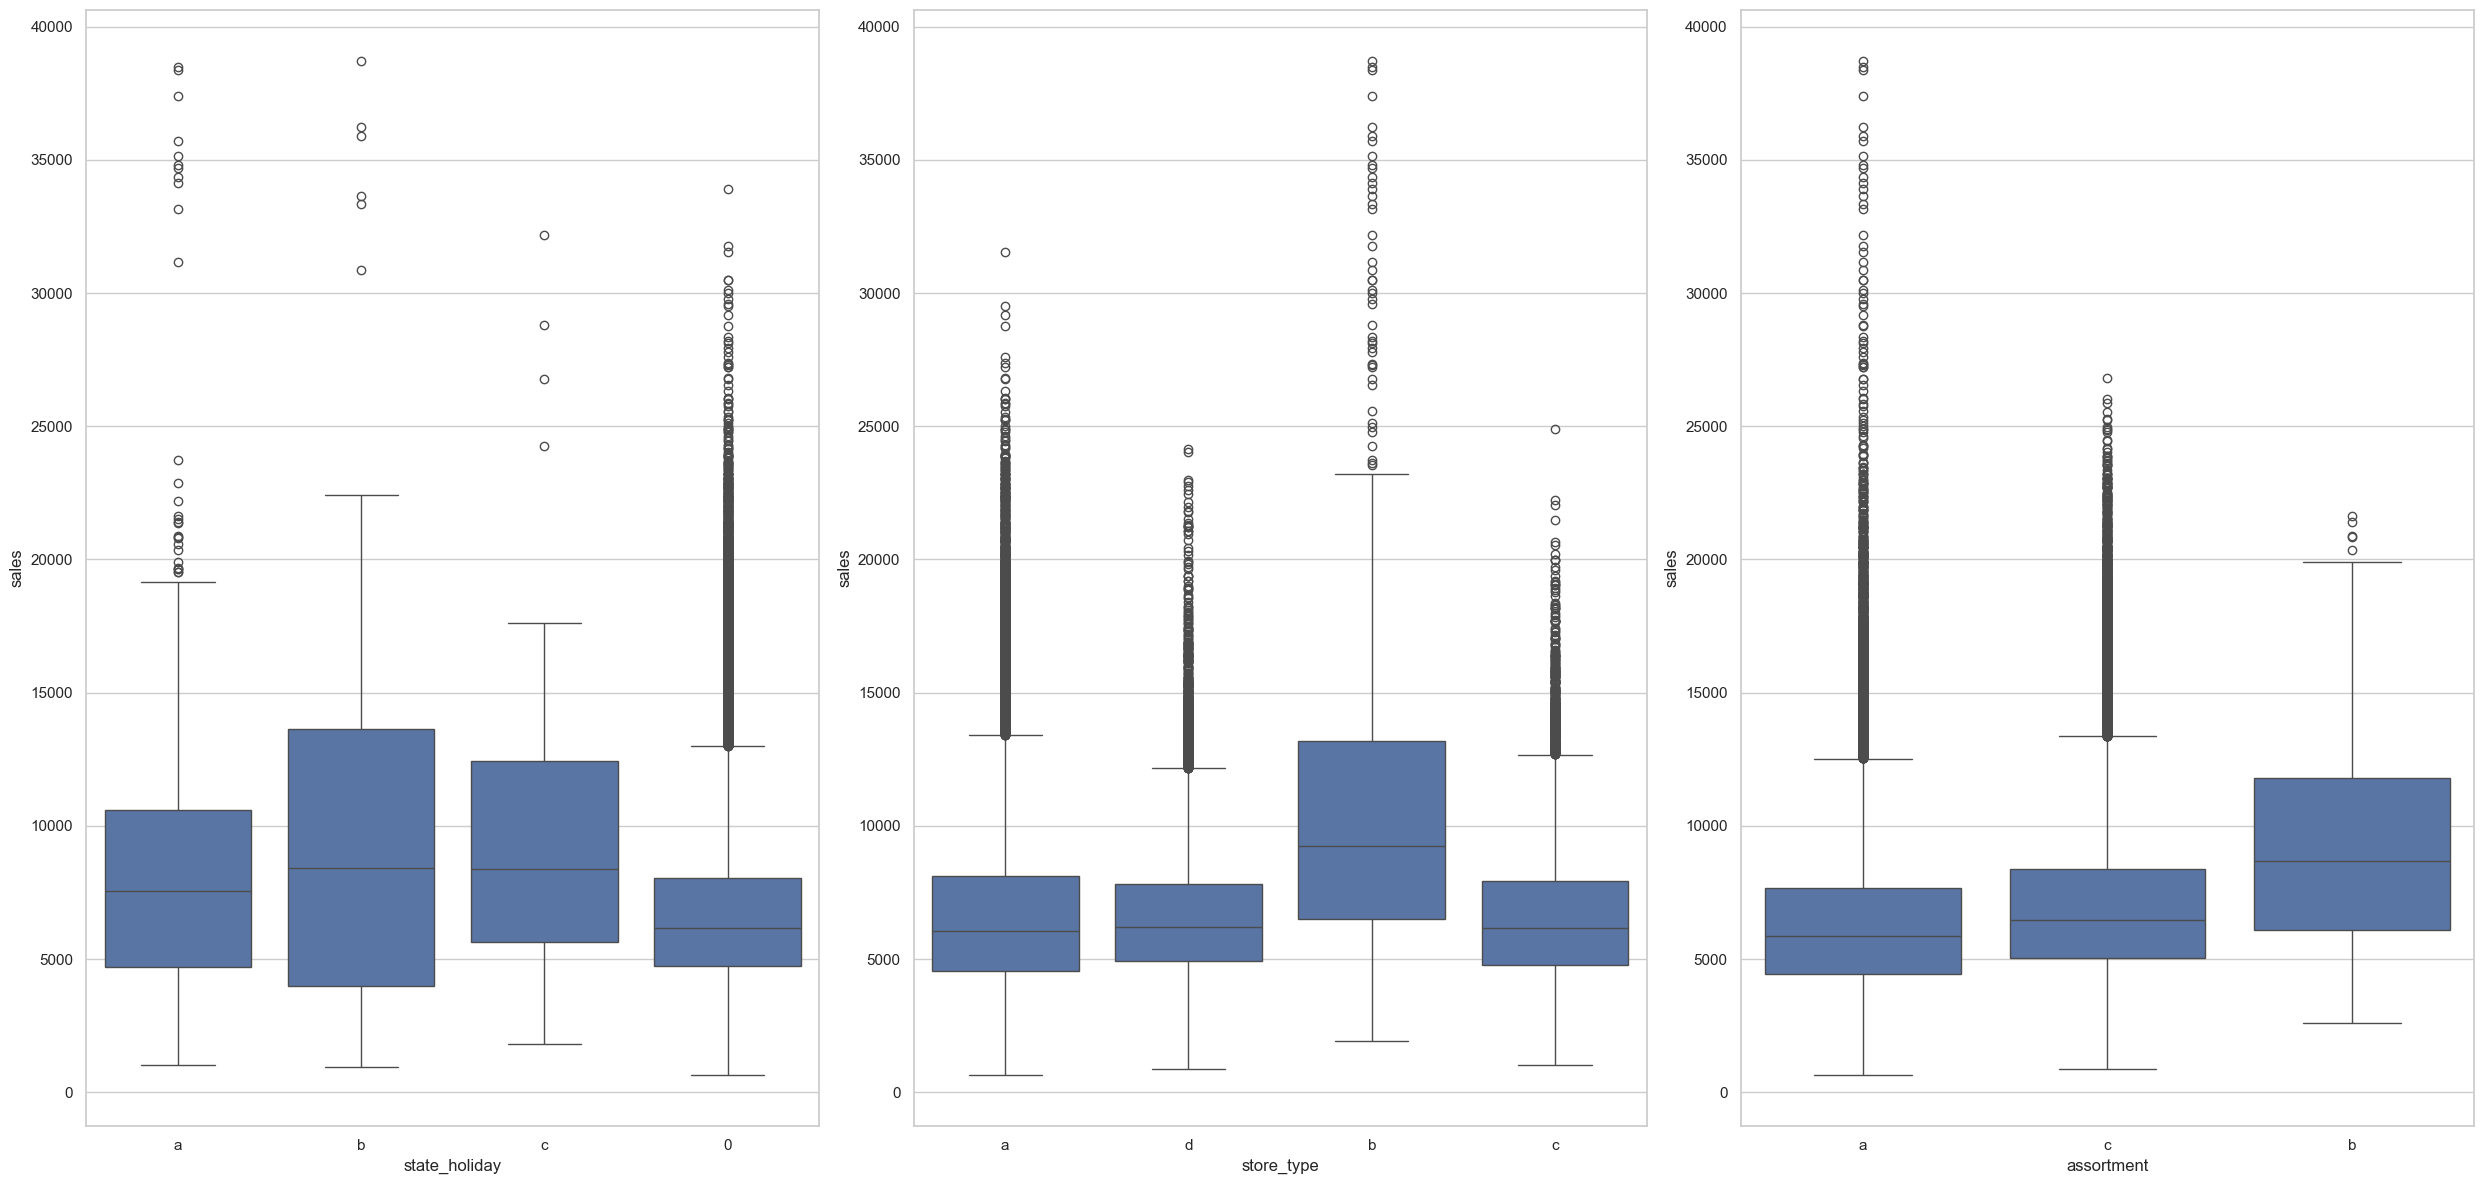

In [34]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )

sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0. FEATURE ENGINEERING

In [35]:
df2 = df1.copy()

## 2.2. Creation of Hypotheses

### 2.2.1. Store Hypotheses

1. Stores with more employees should sell more.

2. Stores with more stock should sell more.

3. Larger stores should sell more.

4. Stores with a larger assortment should sell more.

5. Stores with closer competitors should sell less.

6. Stores with longer competitors should sell more.

### 2.2.2. Product Hypotheses

1. Stores that invest more in marketing should sell more.

2. Stores with more product exposure should sell more.

3. Stores with lower-priced products should sell more.

4. Stores with more aggressive promotions (bigger discounts) should sell more.

5. Stores with longer promotions should sell more.

6. Stores with more promotion days should sell more.

7. Stores with more consecutive promotions should sell more.

### 2.2.3. Time Hypotheses

1. Stores open during the Christmas holidays should sell more.

2. Stores should sell more over the years.

3. Stores should sell more in the second half of the year.

4. Stores should sell more after the 10th of each month.

5. Stores should sell less at weekends.

6. Stores should sell less during school holidays


## 2.3. Final List of Hypotheses

1. Stores with a larger assortment should sell more.

2. Stores with closer competitors should sell less.

3. Stores with longer competitors should sell more.

4. Stores with active promotions for longer should sell more.

5. Stores with more promotion days should sell more.

7. Stores with more consecutive promotions should sell more.

8. Stores open during the Christmas holidays should sell more.

9. Stores should sell more over the years.

10. Stores should sell more in the second half of the year.

11. Stores should sell more after the 10th of each month.

12. Stores should sell less at weekends.

13. Stores should sell less during school holidays.

## 2.4. Feature Engineering

In [36]:
# Dates
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month
df2['day'] = df2['date'].dt.day
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [37]:
# Competition
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(
    year=x['competition_open_since_year'], month=x['competition_open_since_month'], 
    day=1), axis=1)

df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )
                                 /30).apply(lambda x: x.days).astype(int)

In [38]:
# Promo
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'] )/7).apply(
    lambda x: x.days).astype(int)

In [39]:
# Assortment 
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a'
else 'extra' if x == 'b' else 'extended')

# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christimas' if x == 'c' else 'regular_day')

# 3.0. VARIABLE FILTERING

In [40]:
df3 = df2.copy()

In [41]:
# Filtering Rows
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0 )]

# Filtering Cols
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0. EXPLORATORY DATA ANALYSIS 

In [42]:
df4 = df3.copy()

## 4.1. Univariate Analysis 

### 4.1.1 Responde Variable

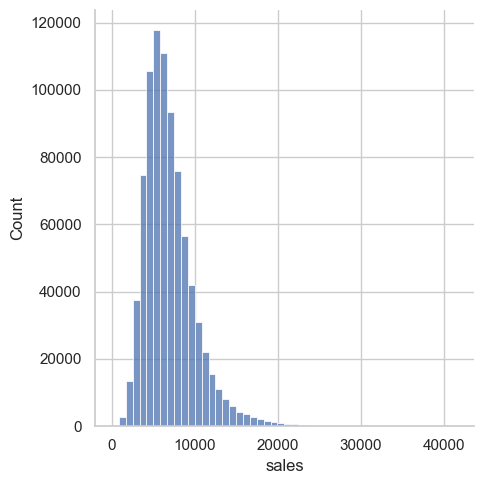

In [43]:
sns.displot(df4['sales'],  bins = 50)

You can see that sales is right-skewed and positive kurtosis, generating this sharp behavior. 

### 4.1.2 Numerical Variable

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>],
       [<Axes: title={'center': 'customers'}>,
        <Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>],
       [<Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>,
        <Axes: title={'center': 'competition_open_since_month'}>],
       [<Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >]], dtype=object)

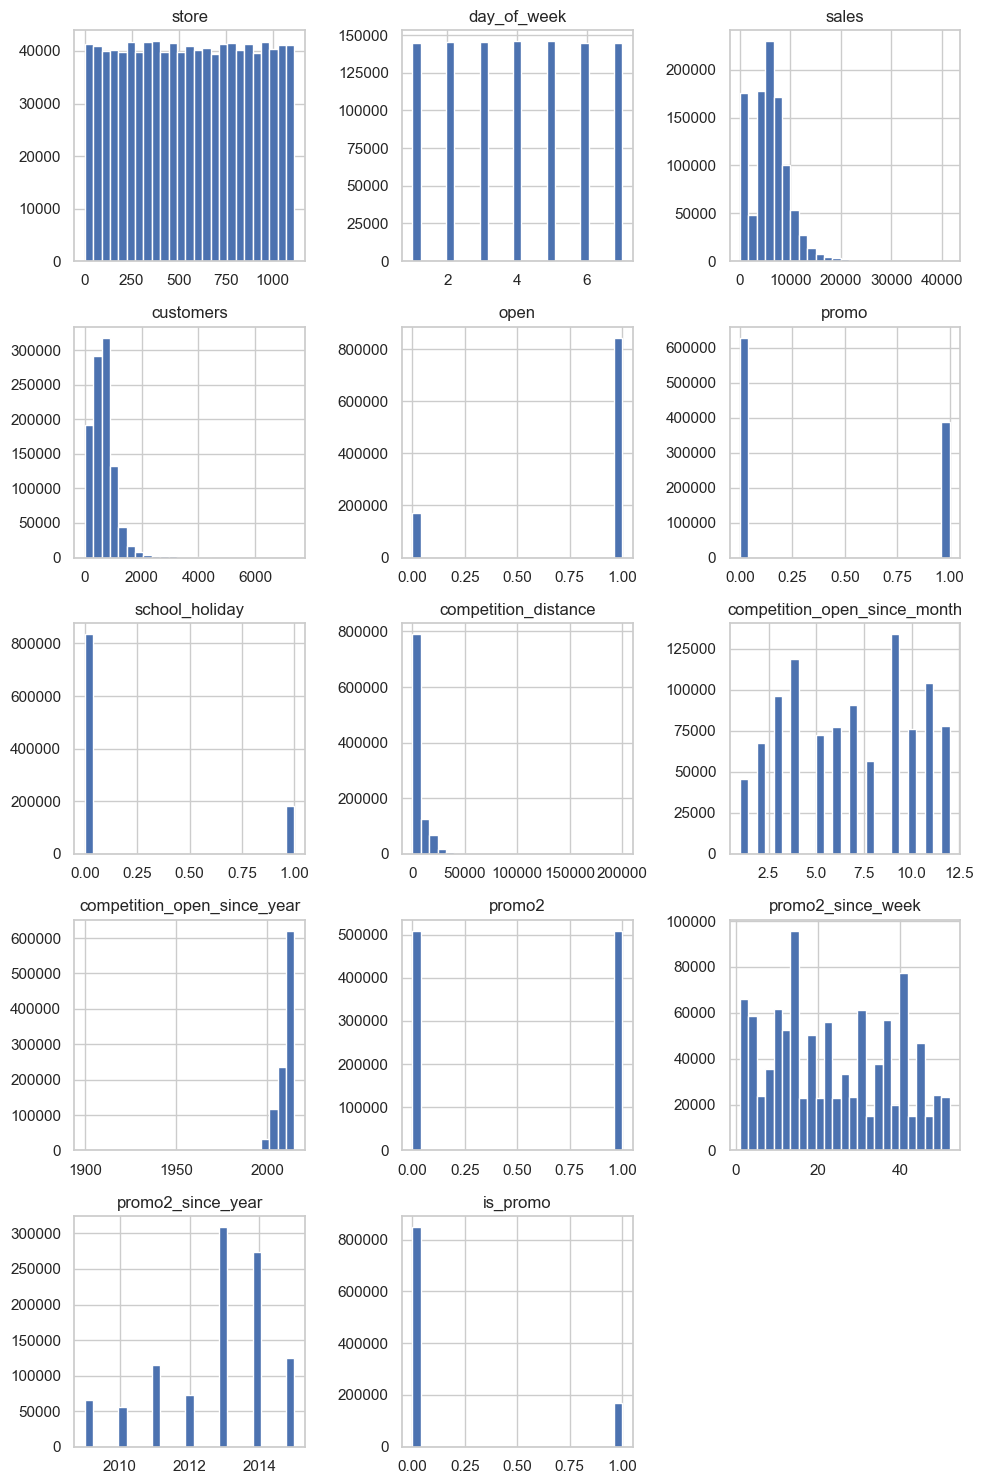

In [44]:
num_attributes.hist( bins=25, layout=(5,3), figsize=(10, 15))

This is just the first step to quickly see the behavior of individual numerical variables.

### 4.1.3 Categorical Variable

In [45]:
df2['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christimas'],
      dtype=object)

<Axes: xlabel='sales', ylabel='Density'>

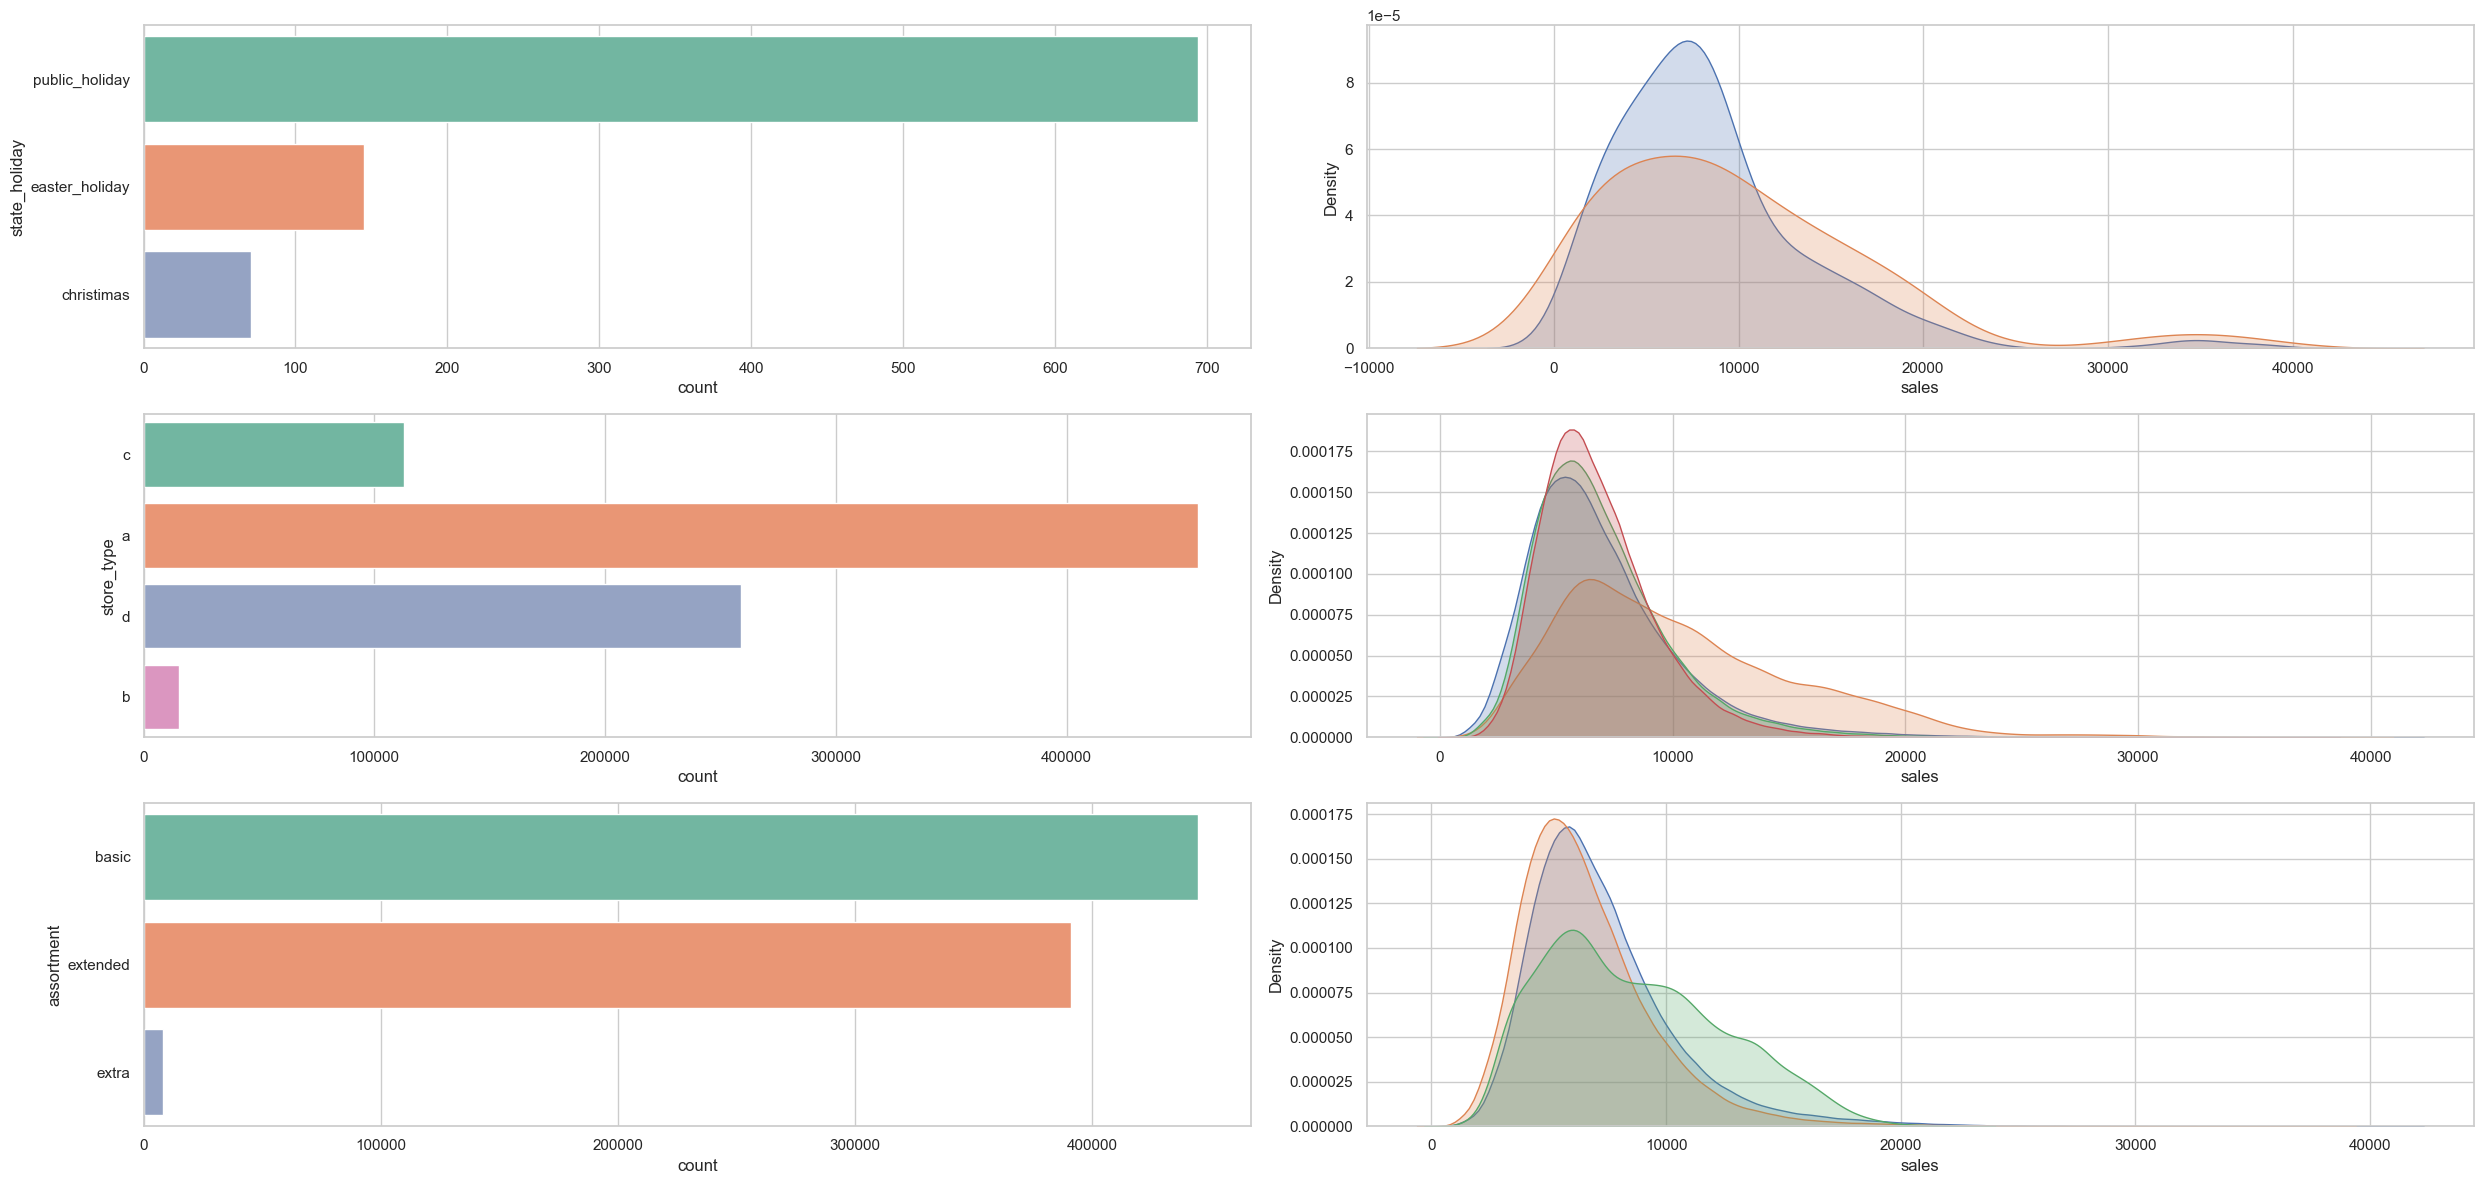

In [46]:
#state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'], palette='Set2' )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )


# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'], palette='Set2' )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'], palette='Set2' )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )


## 4.2. Bivariate Analysis

### H1. Stores with a larger assortment should sell more.

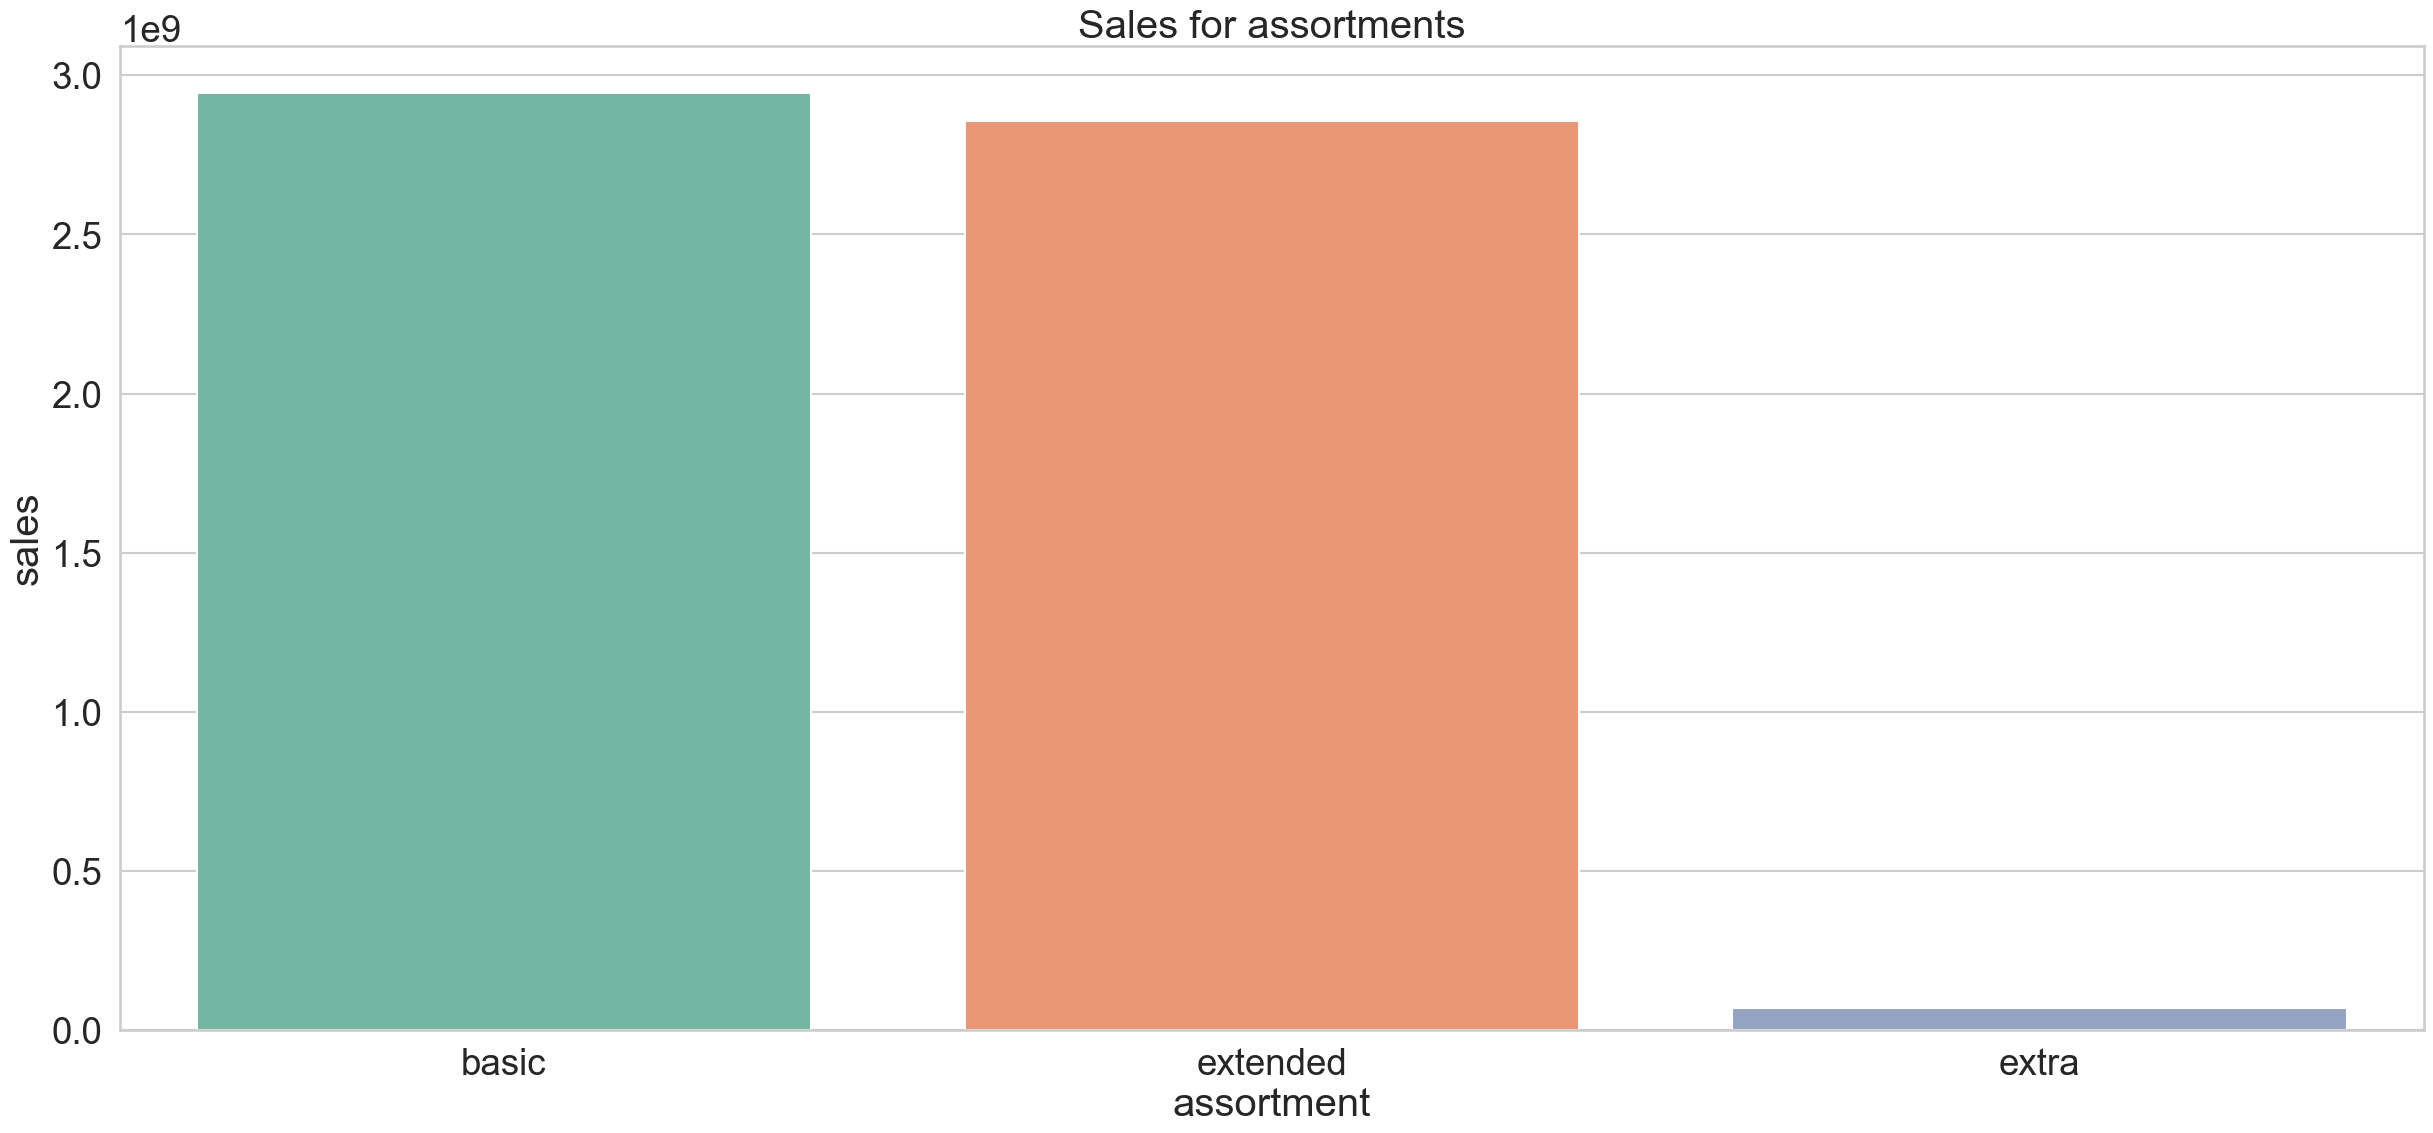

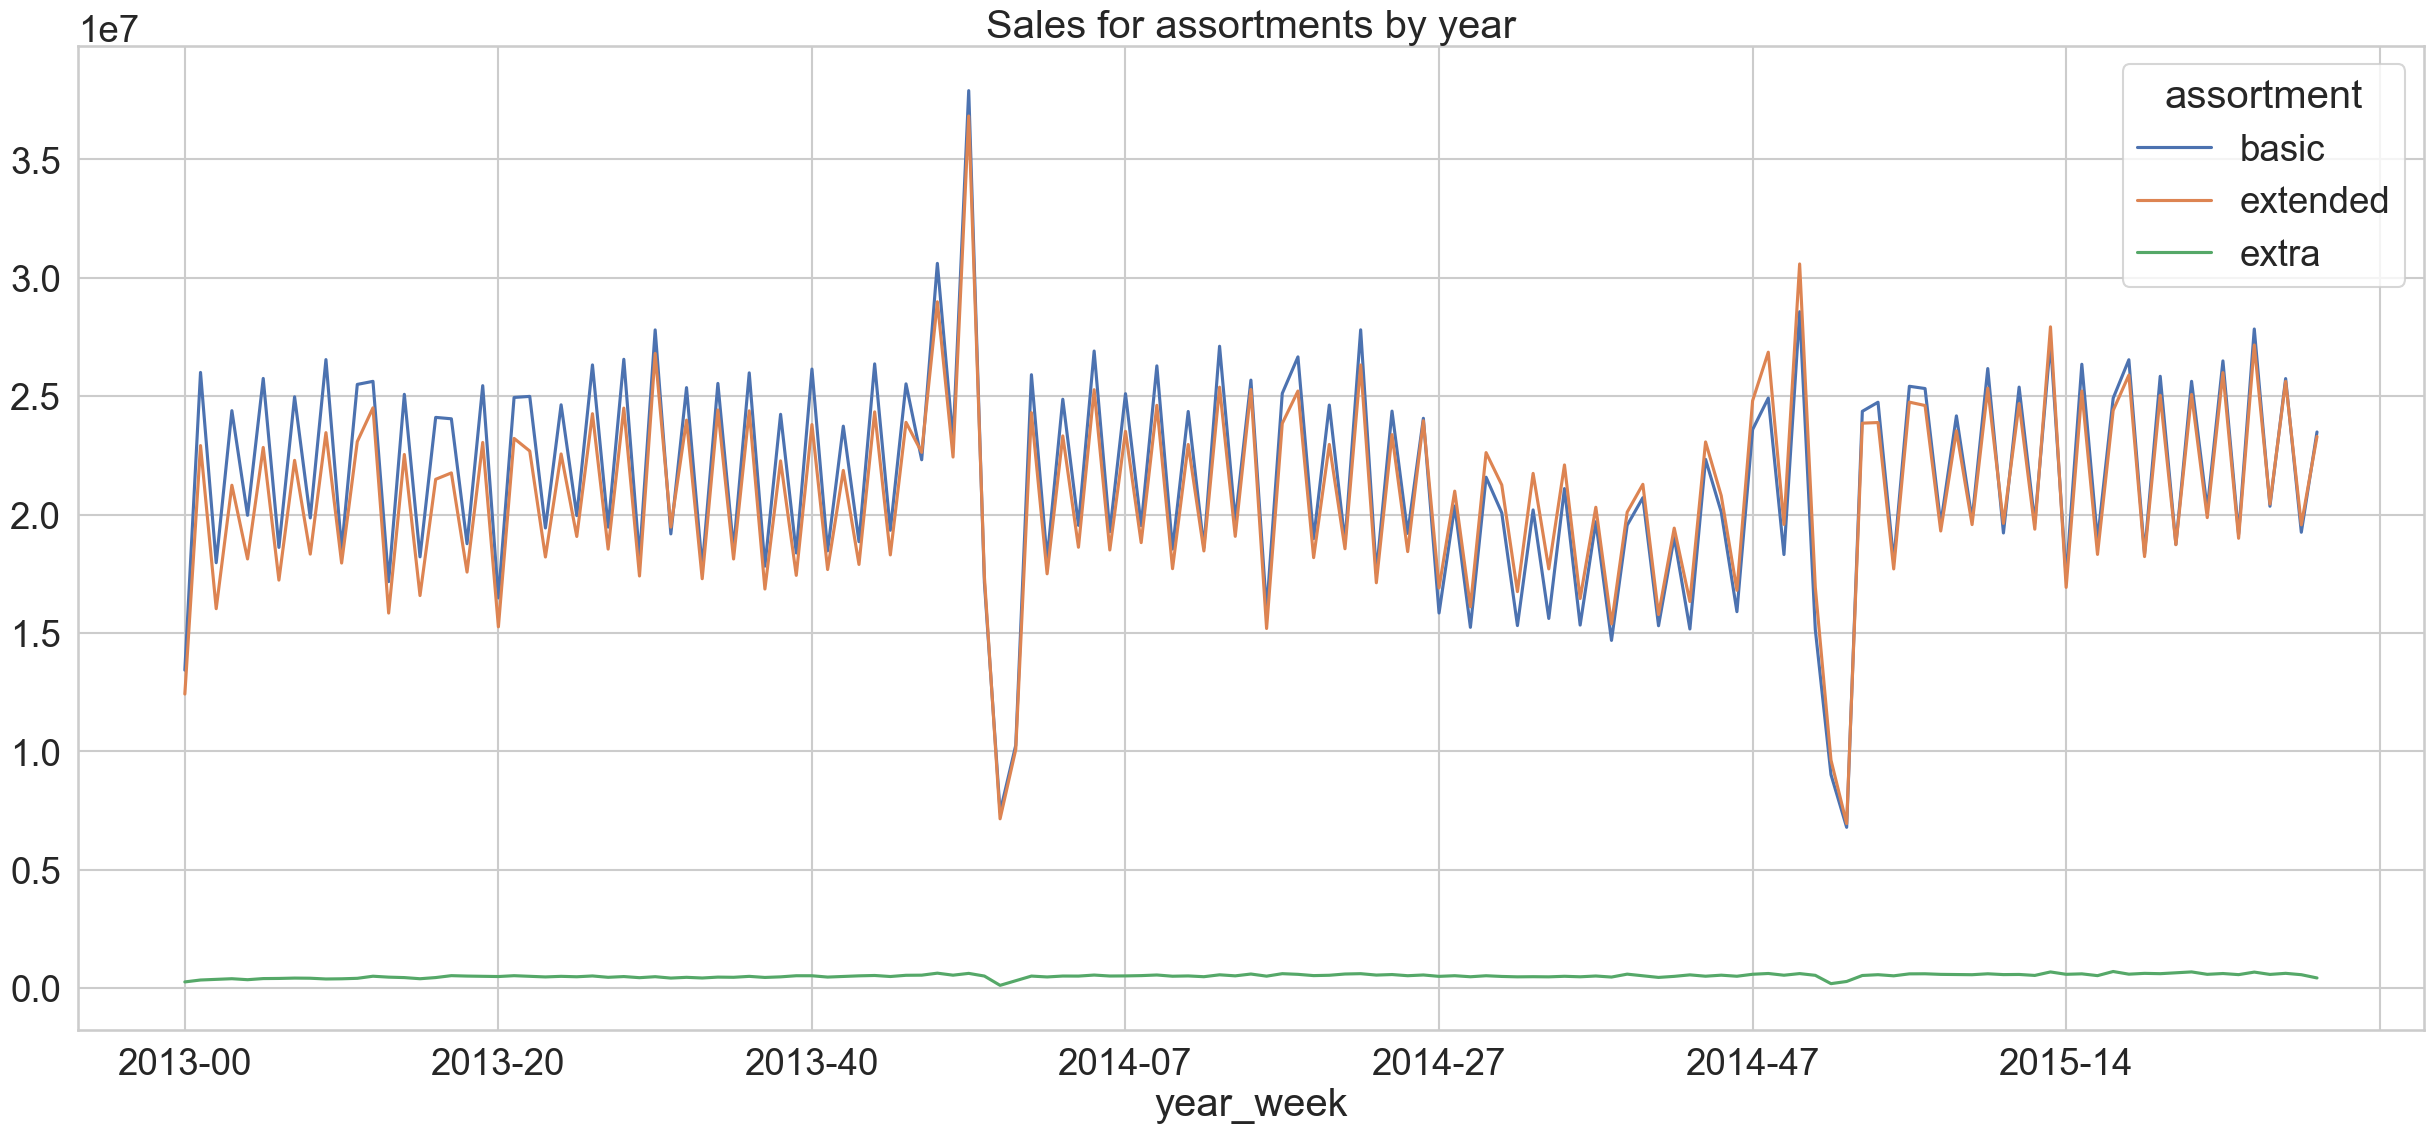

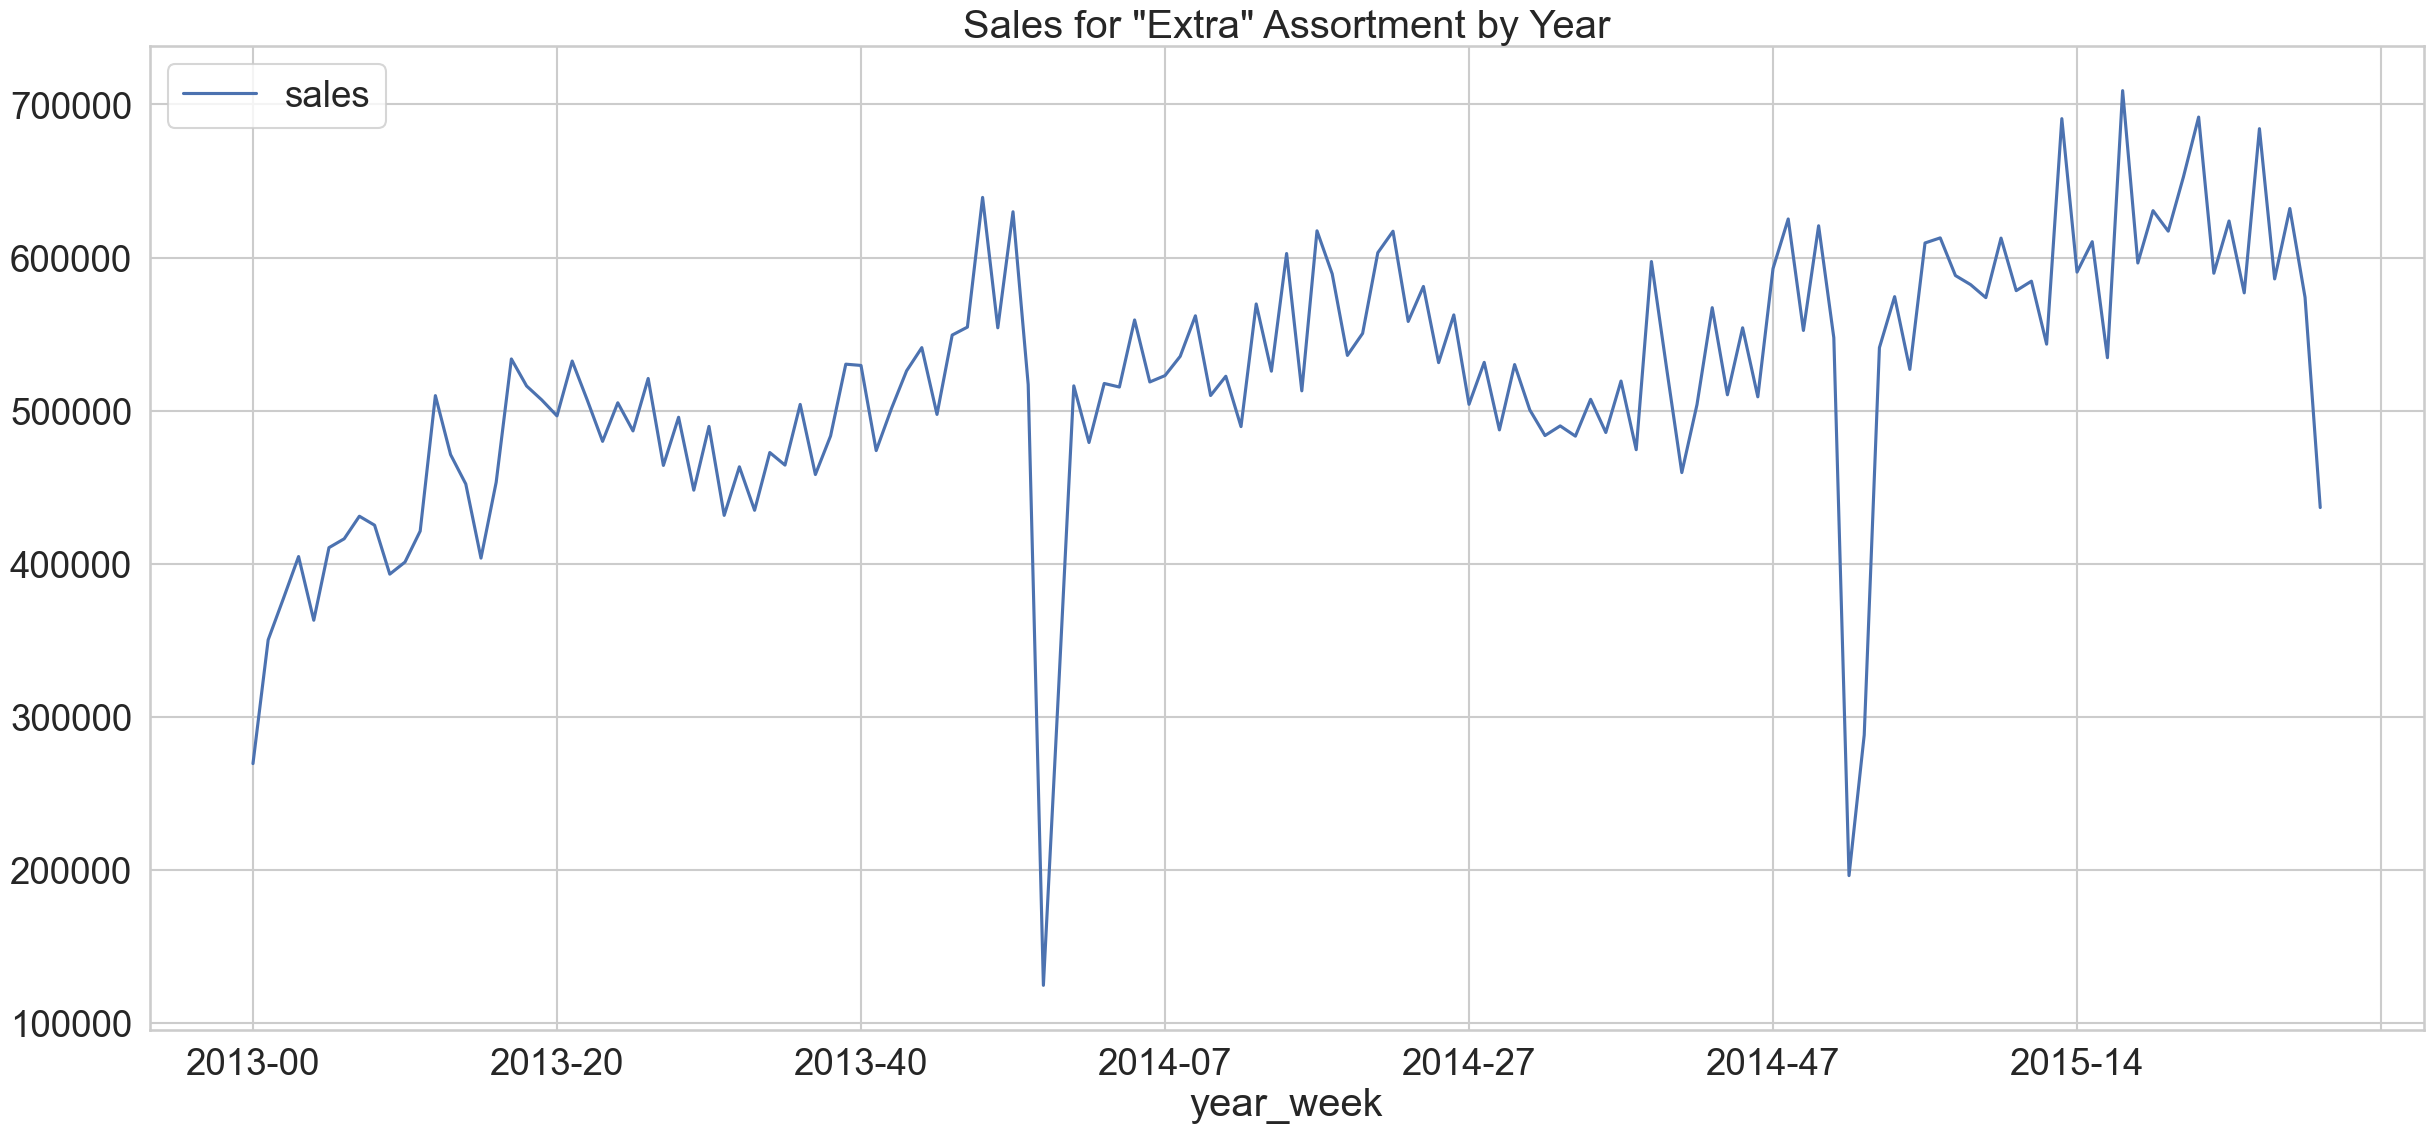

In [47]:
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.6)

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1, palette='Set2')
plt.title('Sales for assortments')
plt.show()

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2_pivot = aux2.pivot(index='year_week', columns='assortment', values='sales')
aux2_pivot.plot()
plt.title('Sales for assortments by year')
plt.show()


aux3 = aux2[aux2['assortment'] == 'extra']
aux3.plot(x='year_week', y='sales', kind='line')
plt.title('Sales for "Extra" Assortment by Year')  
plt.show()


**FALSE HYPOTHESIS**

Stores with less assortment sells more, as we can see on first chart

### H2. Stores with closer competitors should sell less.

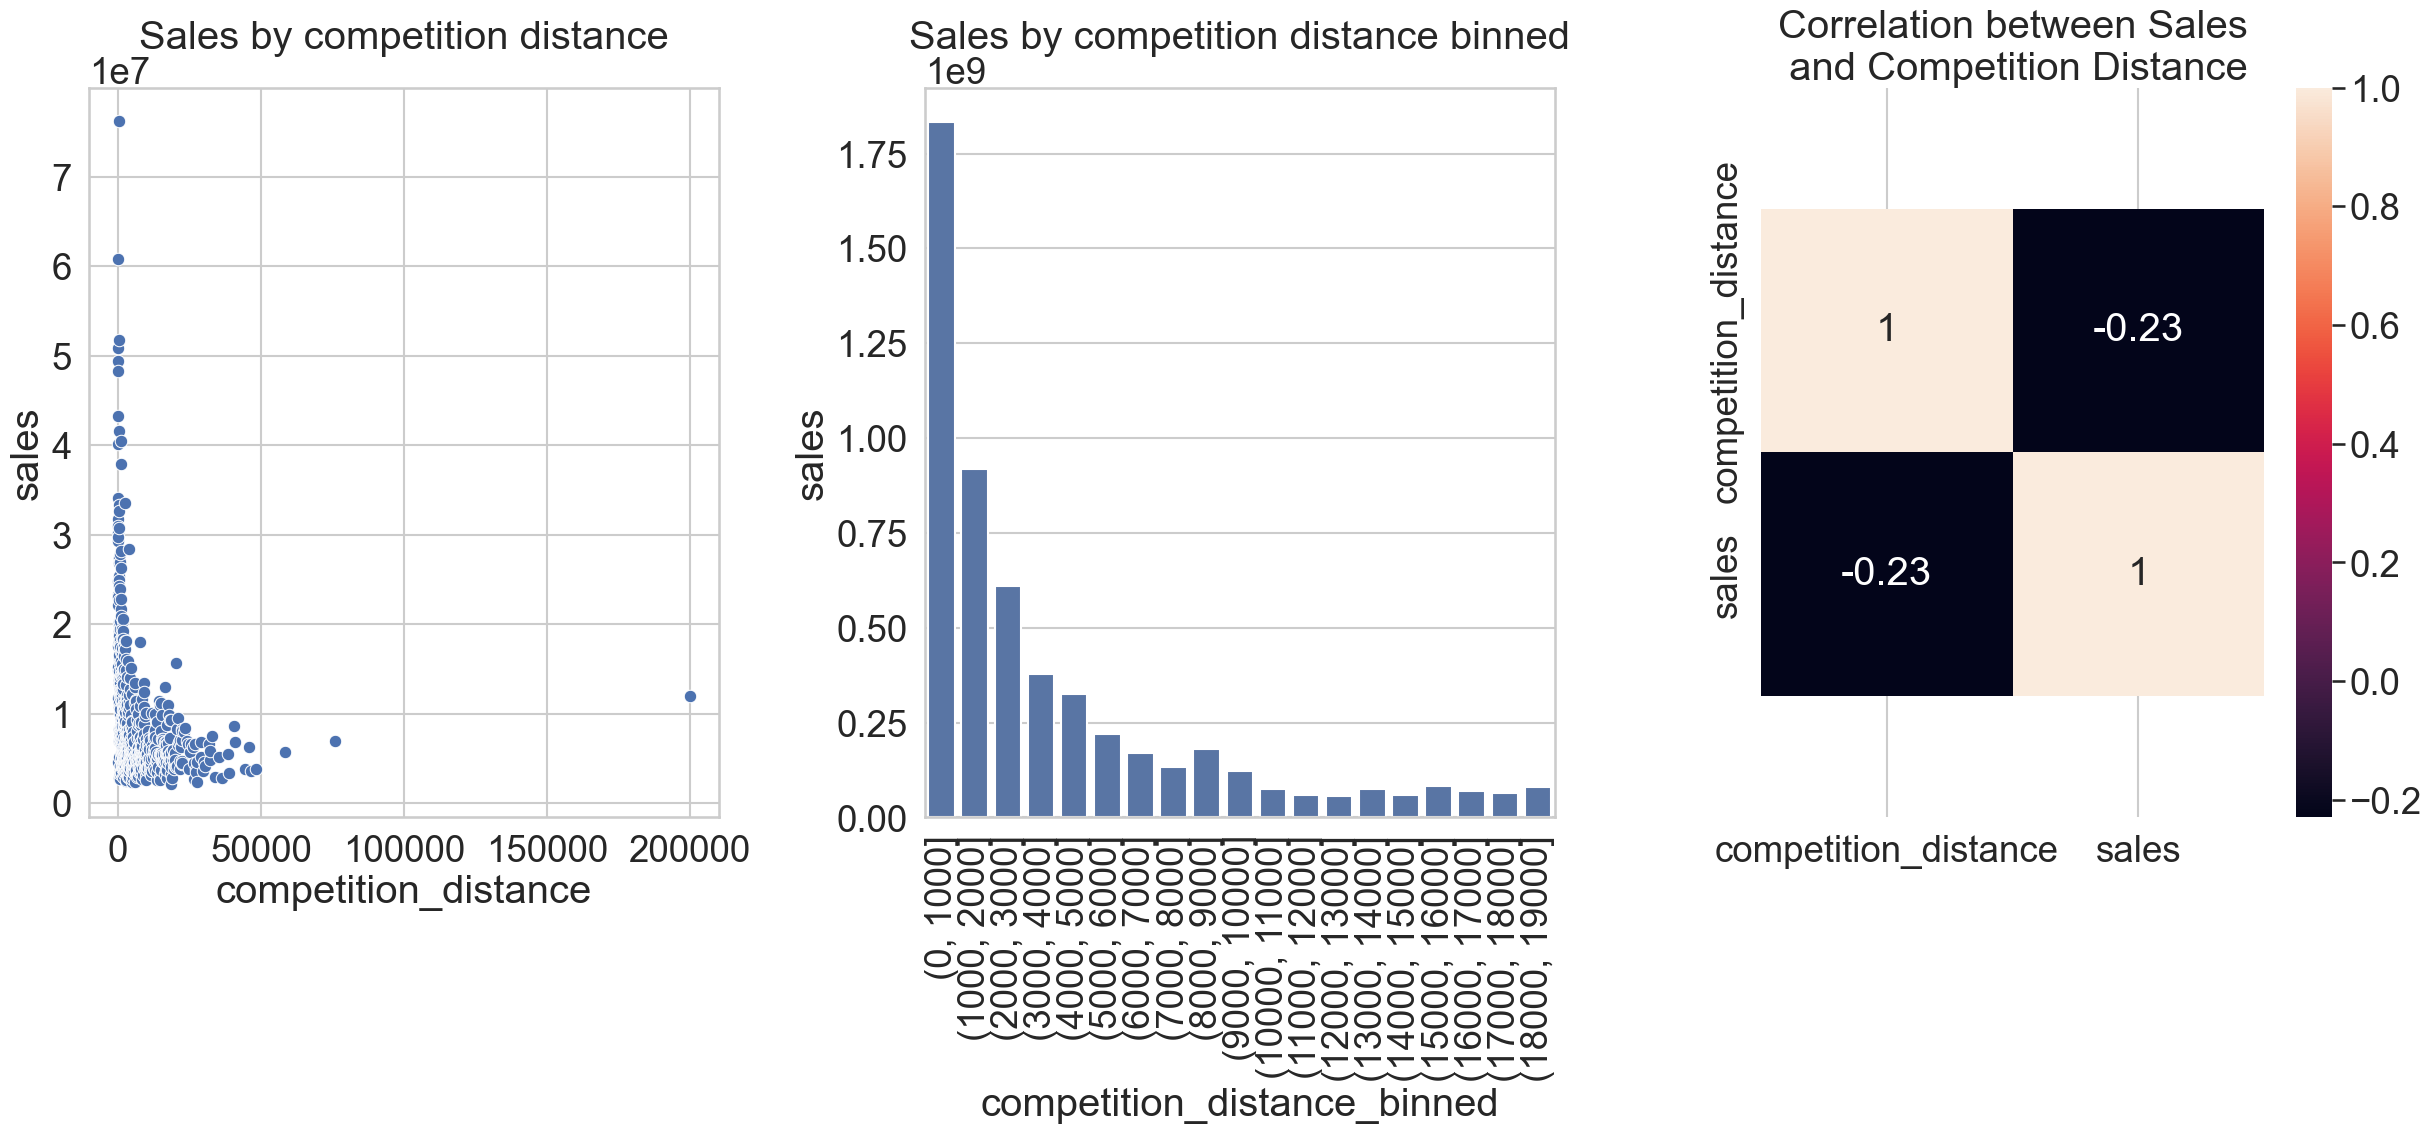

In [48]:
aux1 = df4[['competition_distance', 'sales']].groupby(
    'competition_distance').sum().reset_index()
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.title('Sales by competition distance')

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(
    aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby(
    'competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90)
plt.title('Sales by competition distance binned')

plt.subplot(1, 3, 3)

aux_corr = aux1.drop(columns=['competition_distance_binned'])
x = sns.heatmap(aux_corr.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5)
plt.title('Correlation between Sales\n and Competition Distance')
plt.tight_layout()
plt.show()


**FALSE HYPOTHESIS**

As we can see, the sales decrease as competitors move away.  is probably because it creates a sales center where people know where it is, so the closer the competitor, the more sales. 

### H3. Stores with longer competitors should sell more.

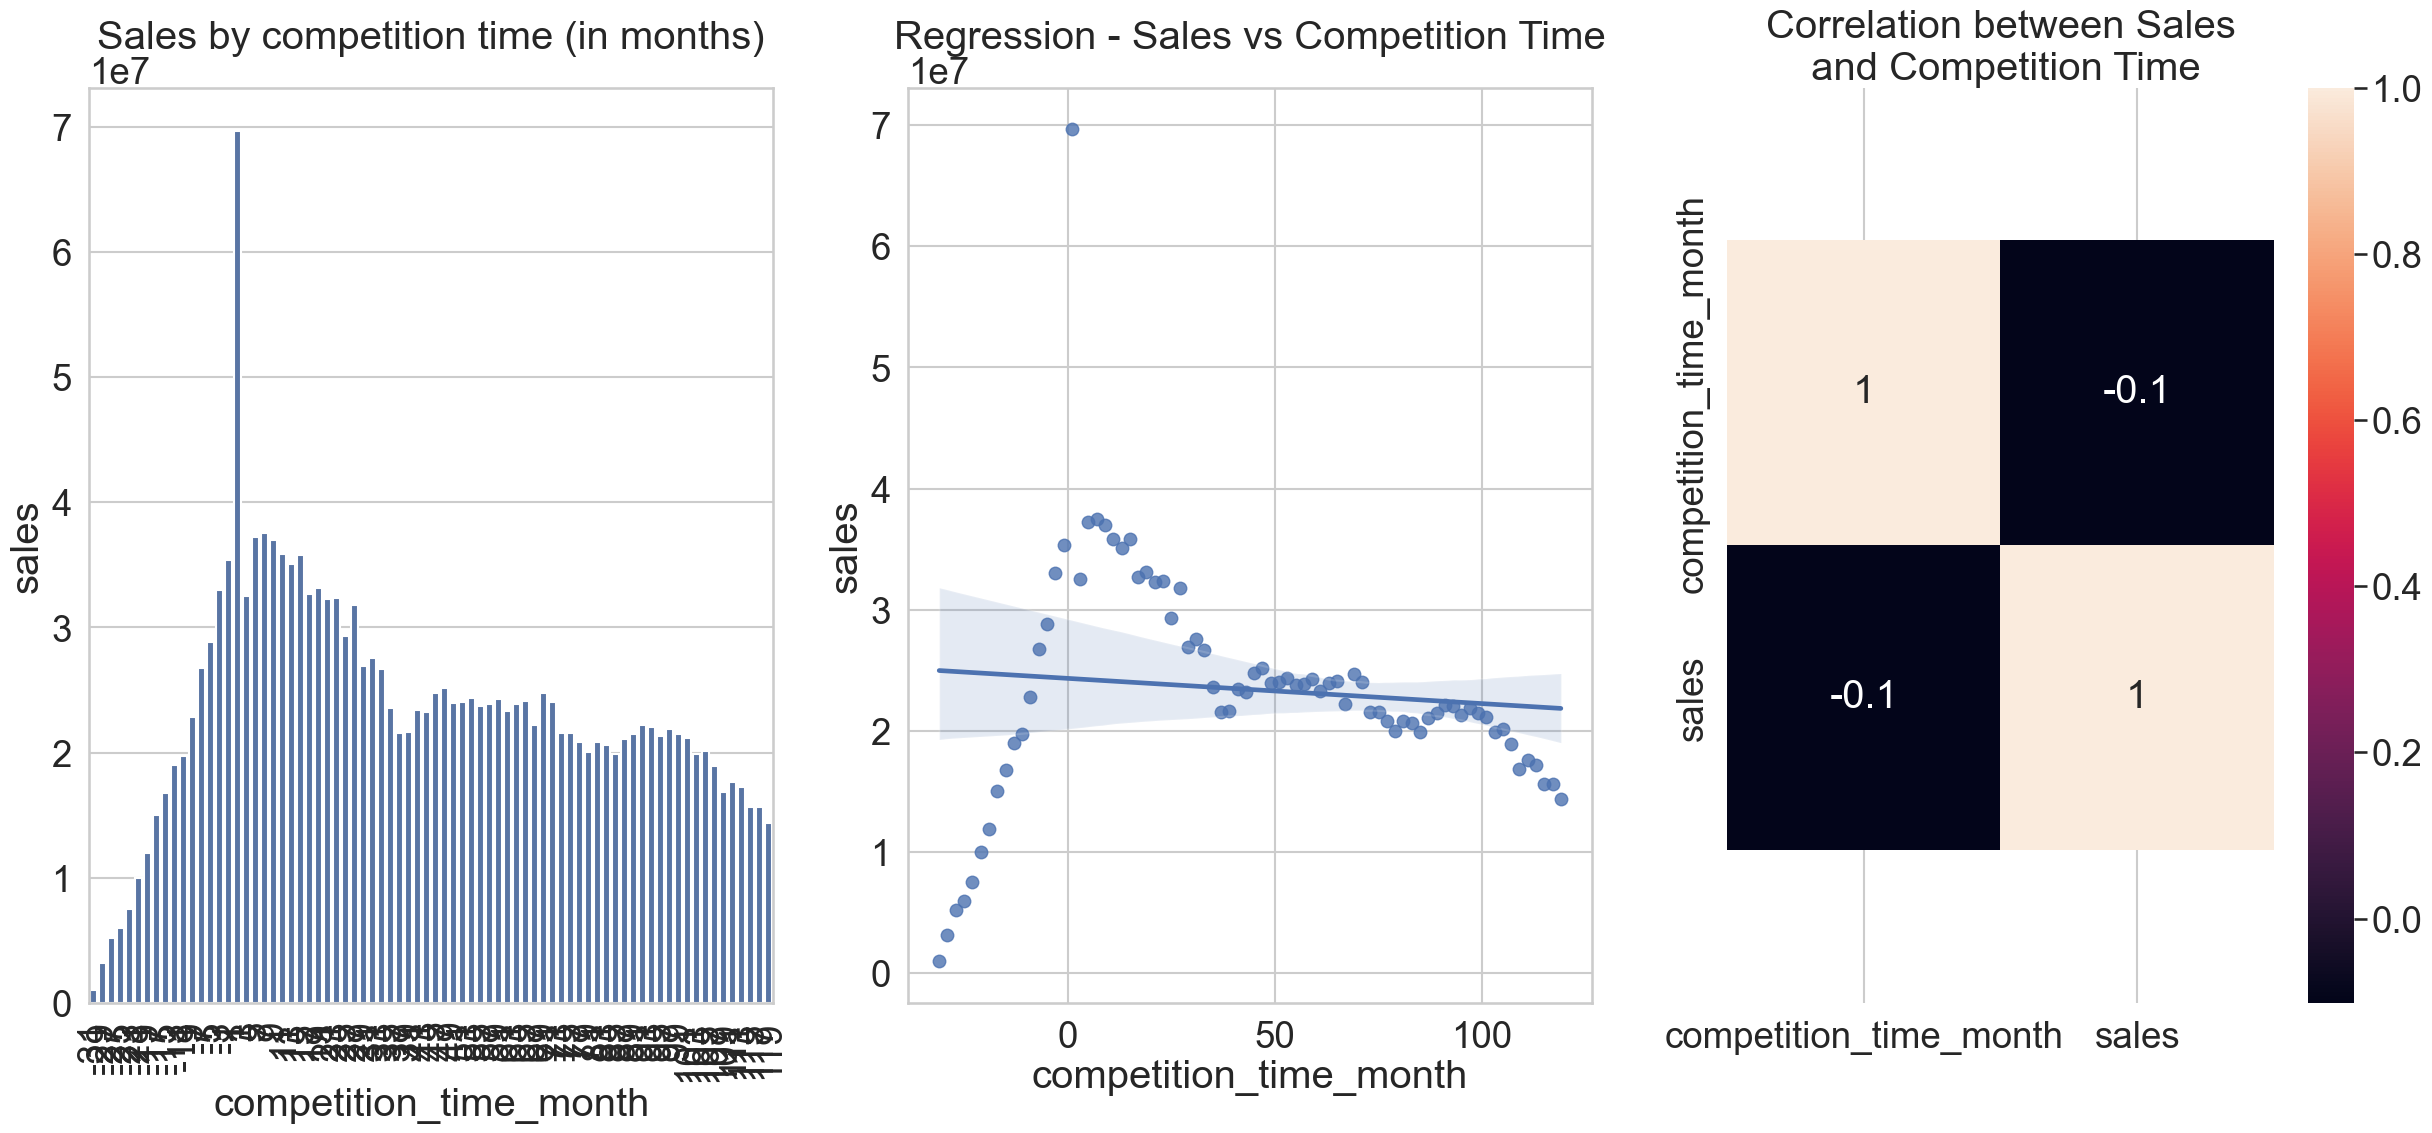

In [49]:
aux1  = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 )&
            aux1['competition_time_month'] != 0 ]
plt.subplot(1, 3, 1)
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)
plt.title('Sales by competition time (in months)')
plt.xticks(rotation = 90)

plt.subplot(1,3,2)
sns.regplot(data=aux2, x = 'competition_time_month', y = 'sales')
plt.title('Regression - Sales vs Competition Time')

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot = True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top -0.5)
plt.title('Correlation between Sales\n and Competition Time')
plt.show()

**FALSE HYPOTHESIS**

As competitors' time increases, sales decrease. 


### H4. Stores with active promotions for longer should sell more.

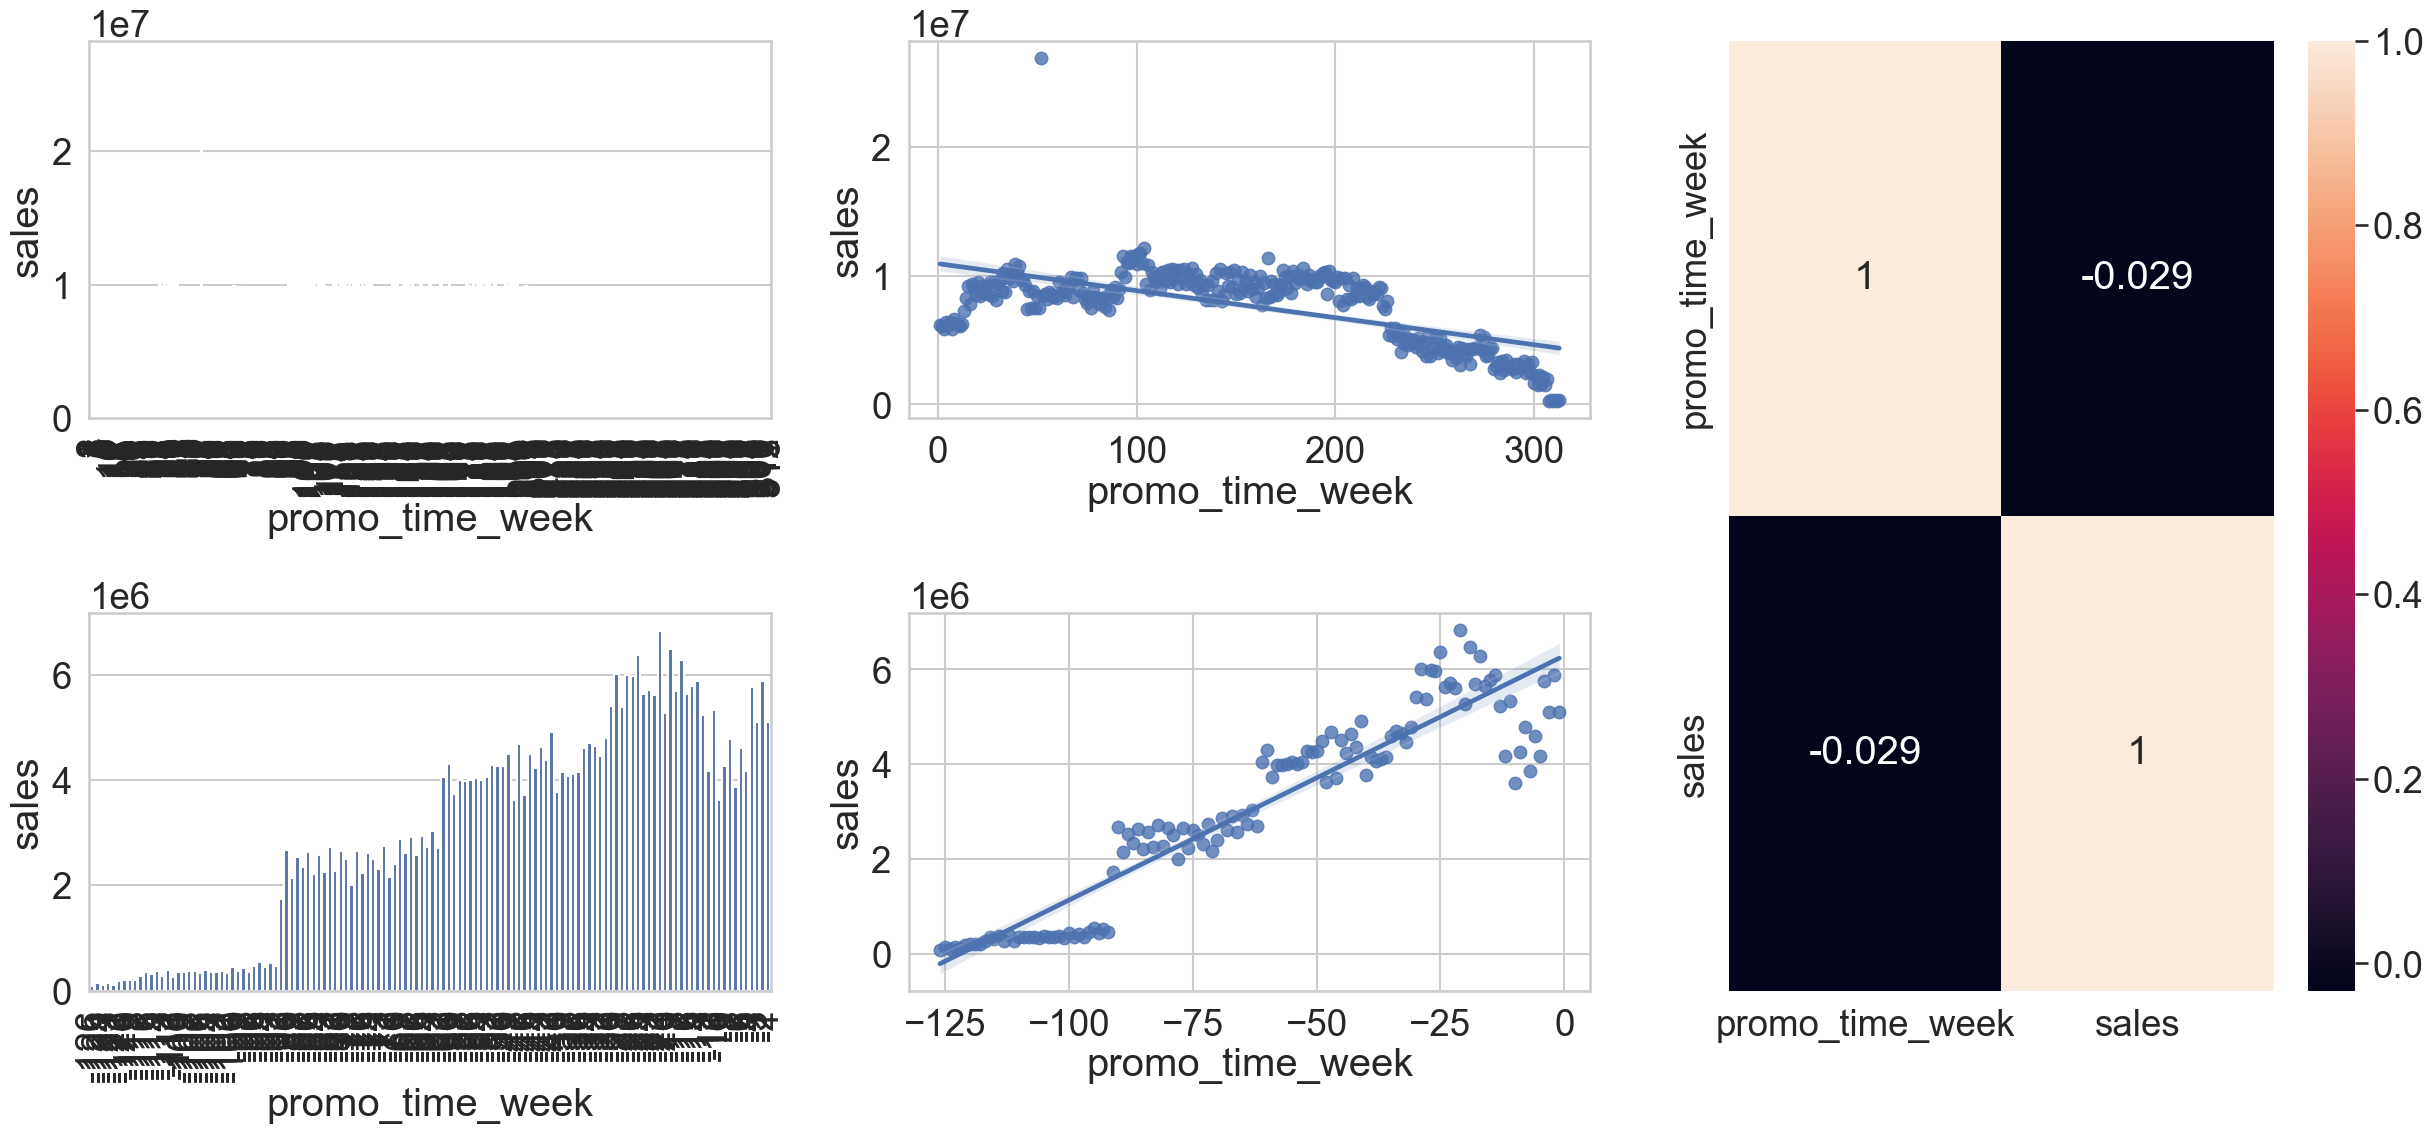

In [50]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()
grid = GridSpec( 2, 3 )
plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


**FALSE HYPOTHESIS**

As promotions run longer, sales fall

### H5. Stores with more consecutive promotions should sell more.

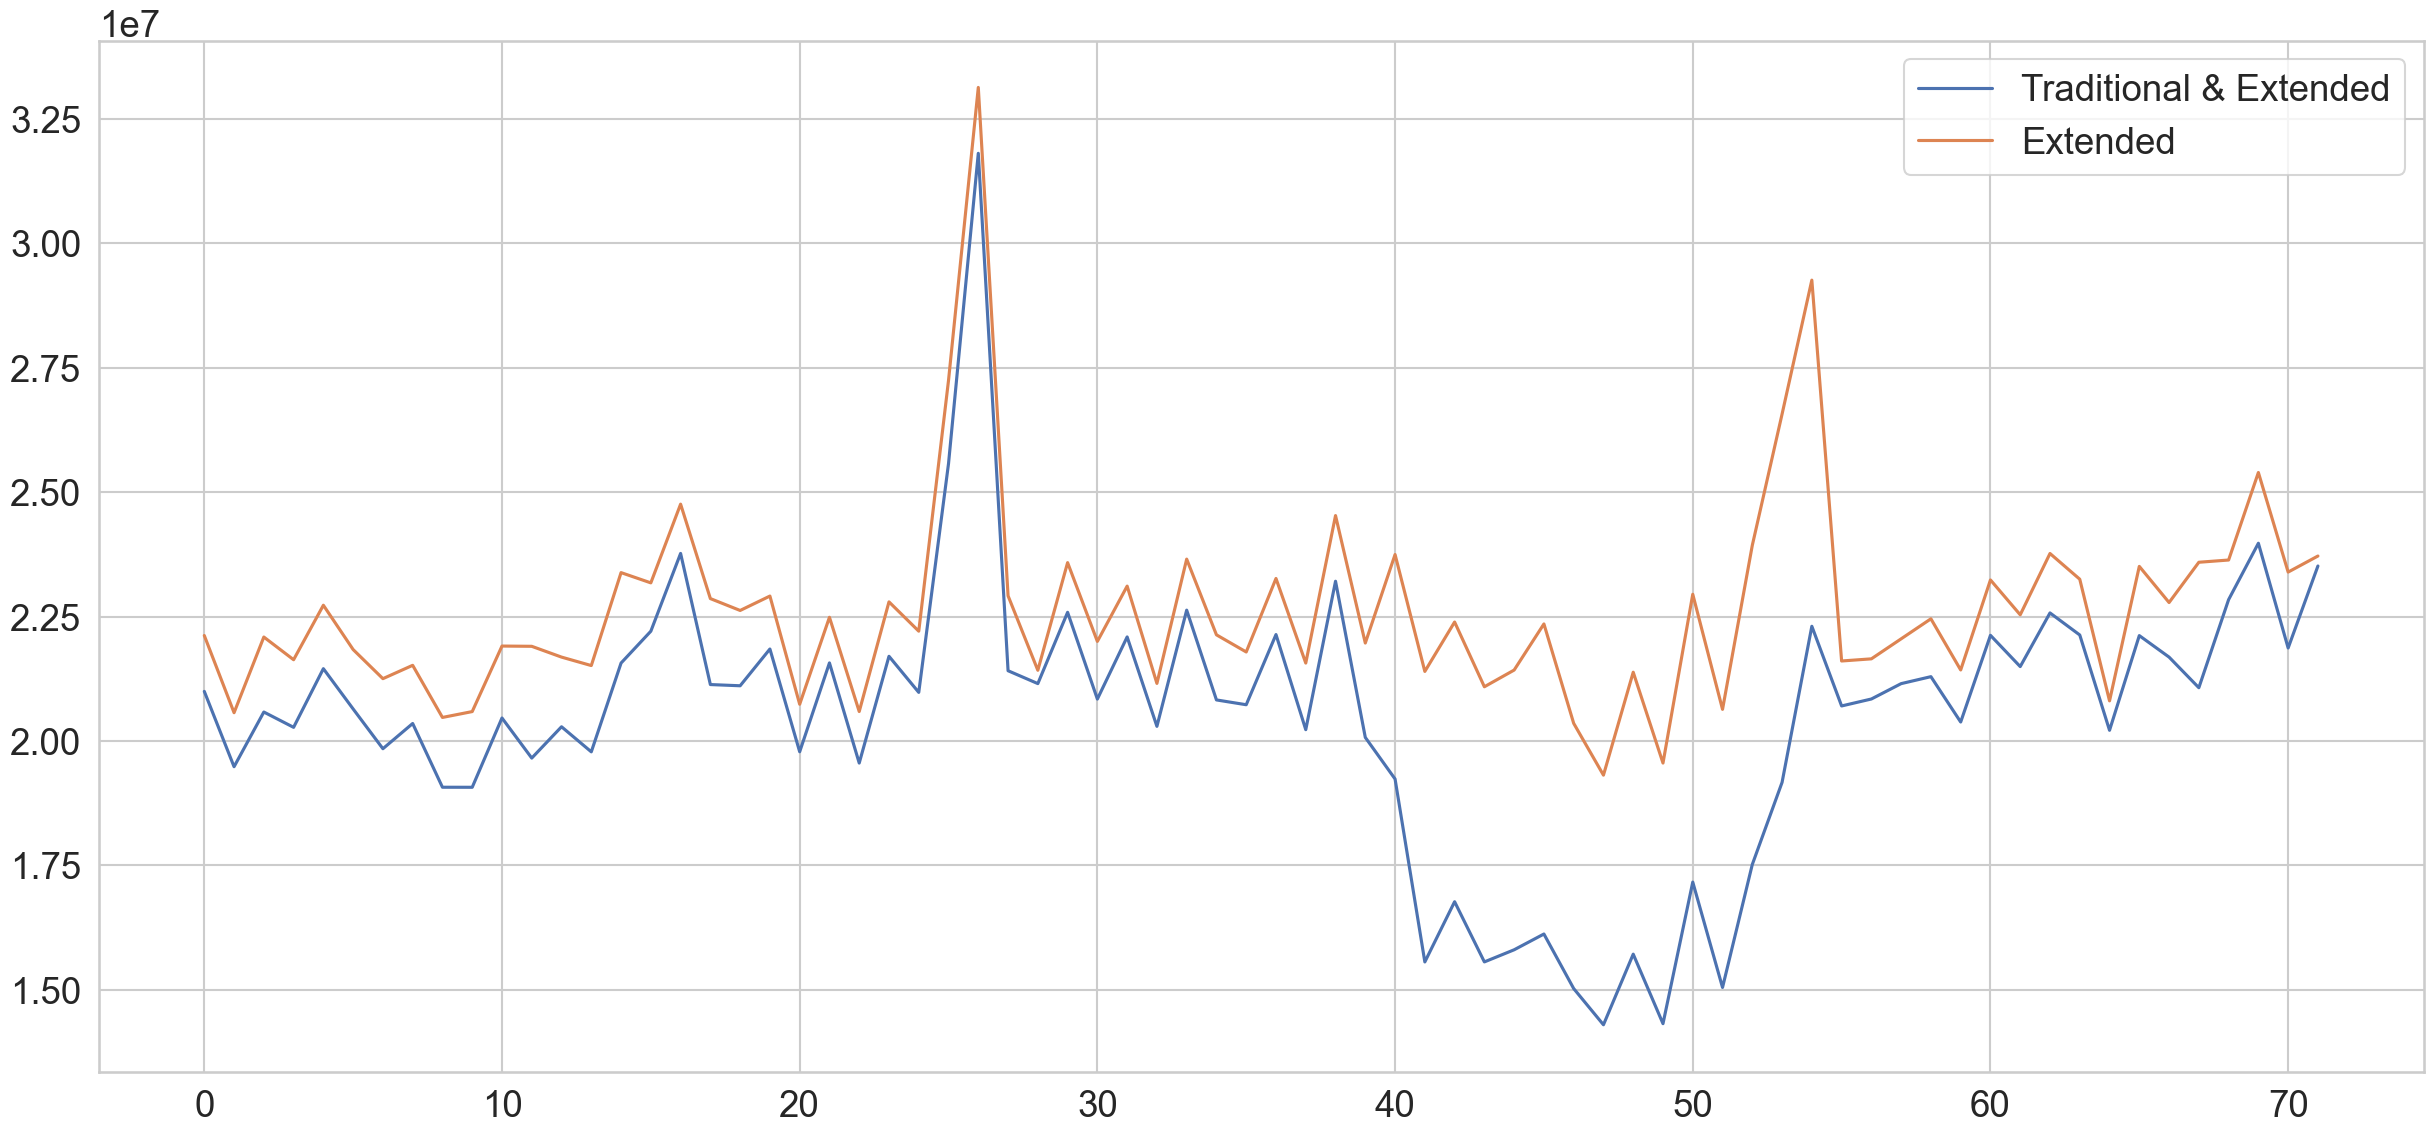

In [51]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )
           ][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )
           ][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )
ax.legend( labels=['Traditional & Extended', 'Extended']);


**FALSE HYPOTHESIS**

We can see a drop in the chart when it's extended

### H6. Stores open during the Christmas holidays should sell more.

<Axes: xlabel='year', ylabel='sales'>

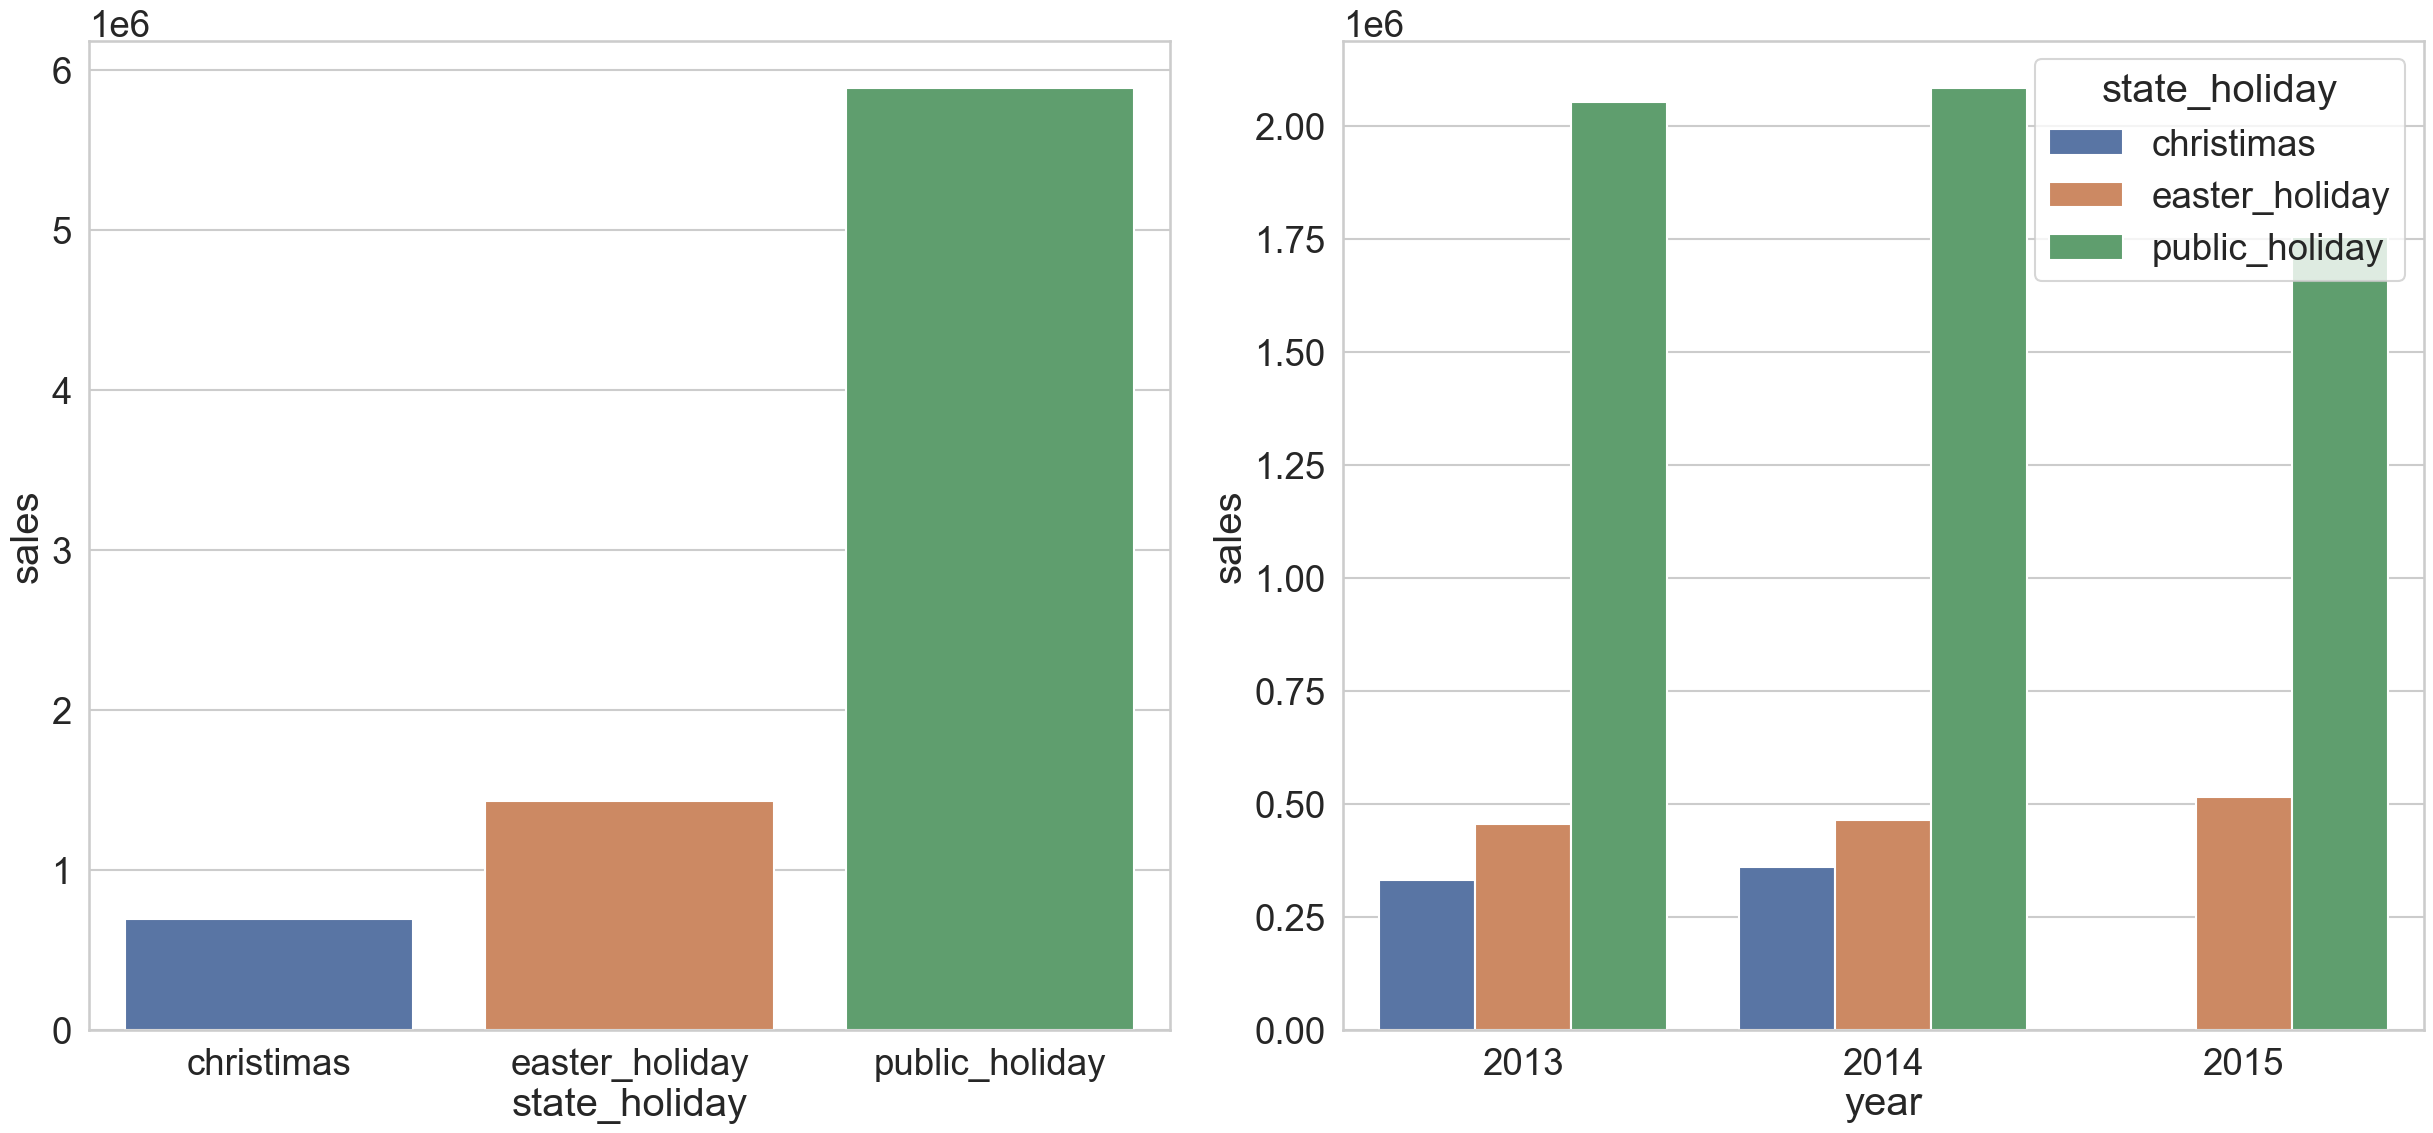

In [52]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby(
     'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 , hue='state_holiday')

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']
           ].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 )

**FALSE HYPOTHESIS**

Christmas is the holiday that sells the least among those presented in the database

### H7. Stores should sell more over the years.

<Axes: >

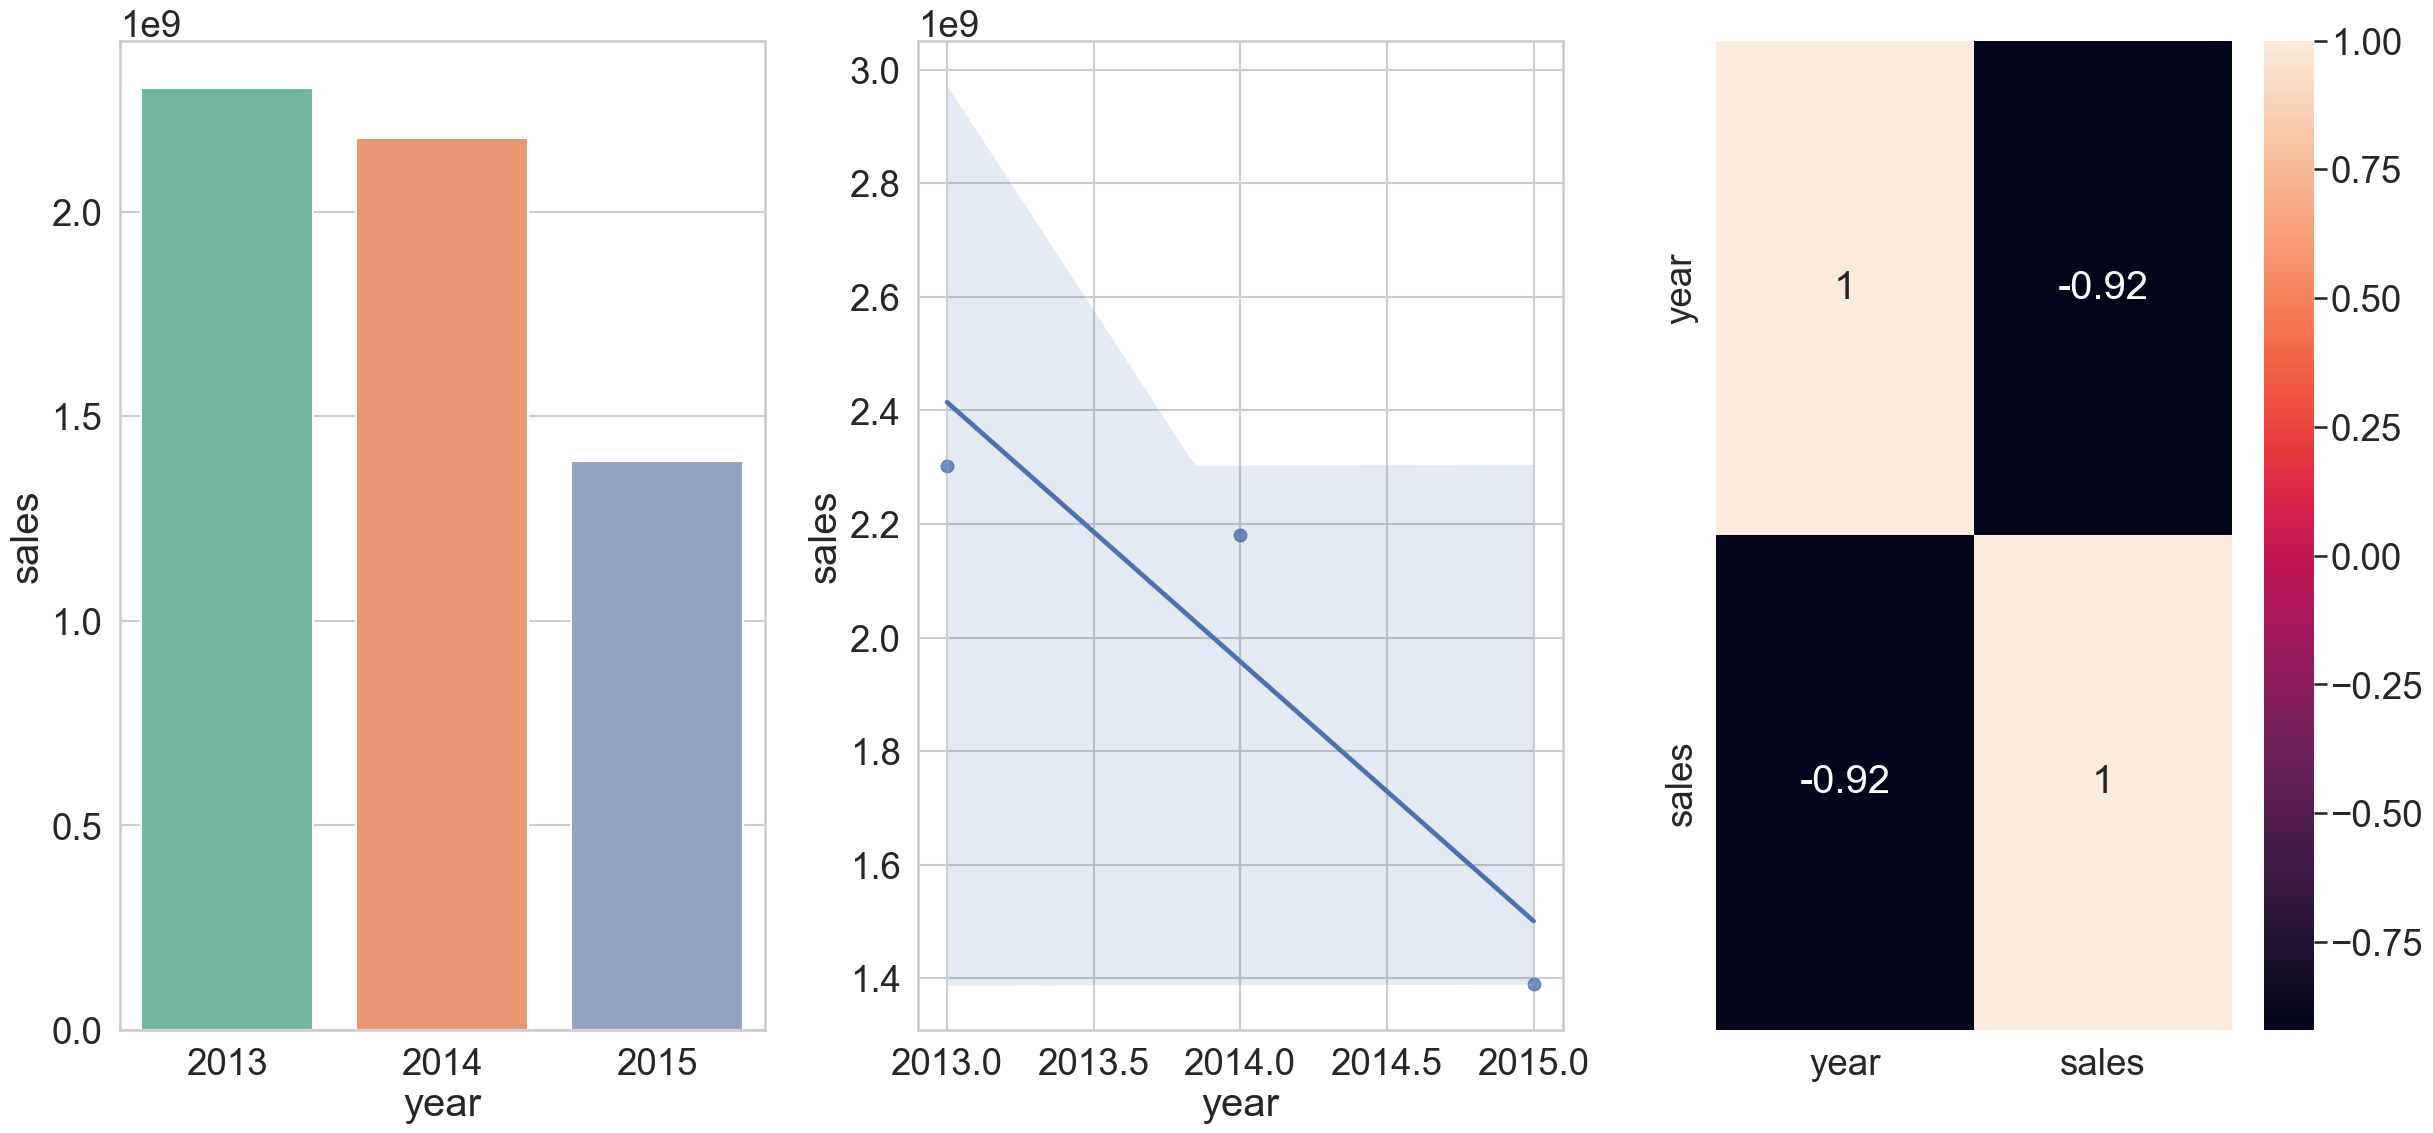

In [53]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 , palette='Set2')

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )


**FALSE HYPOTHESIS**

It's exactly the opposite. As time goes by, sales decrease

### H8. Stores should sell more in the second half of the year.

<Axes: >

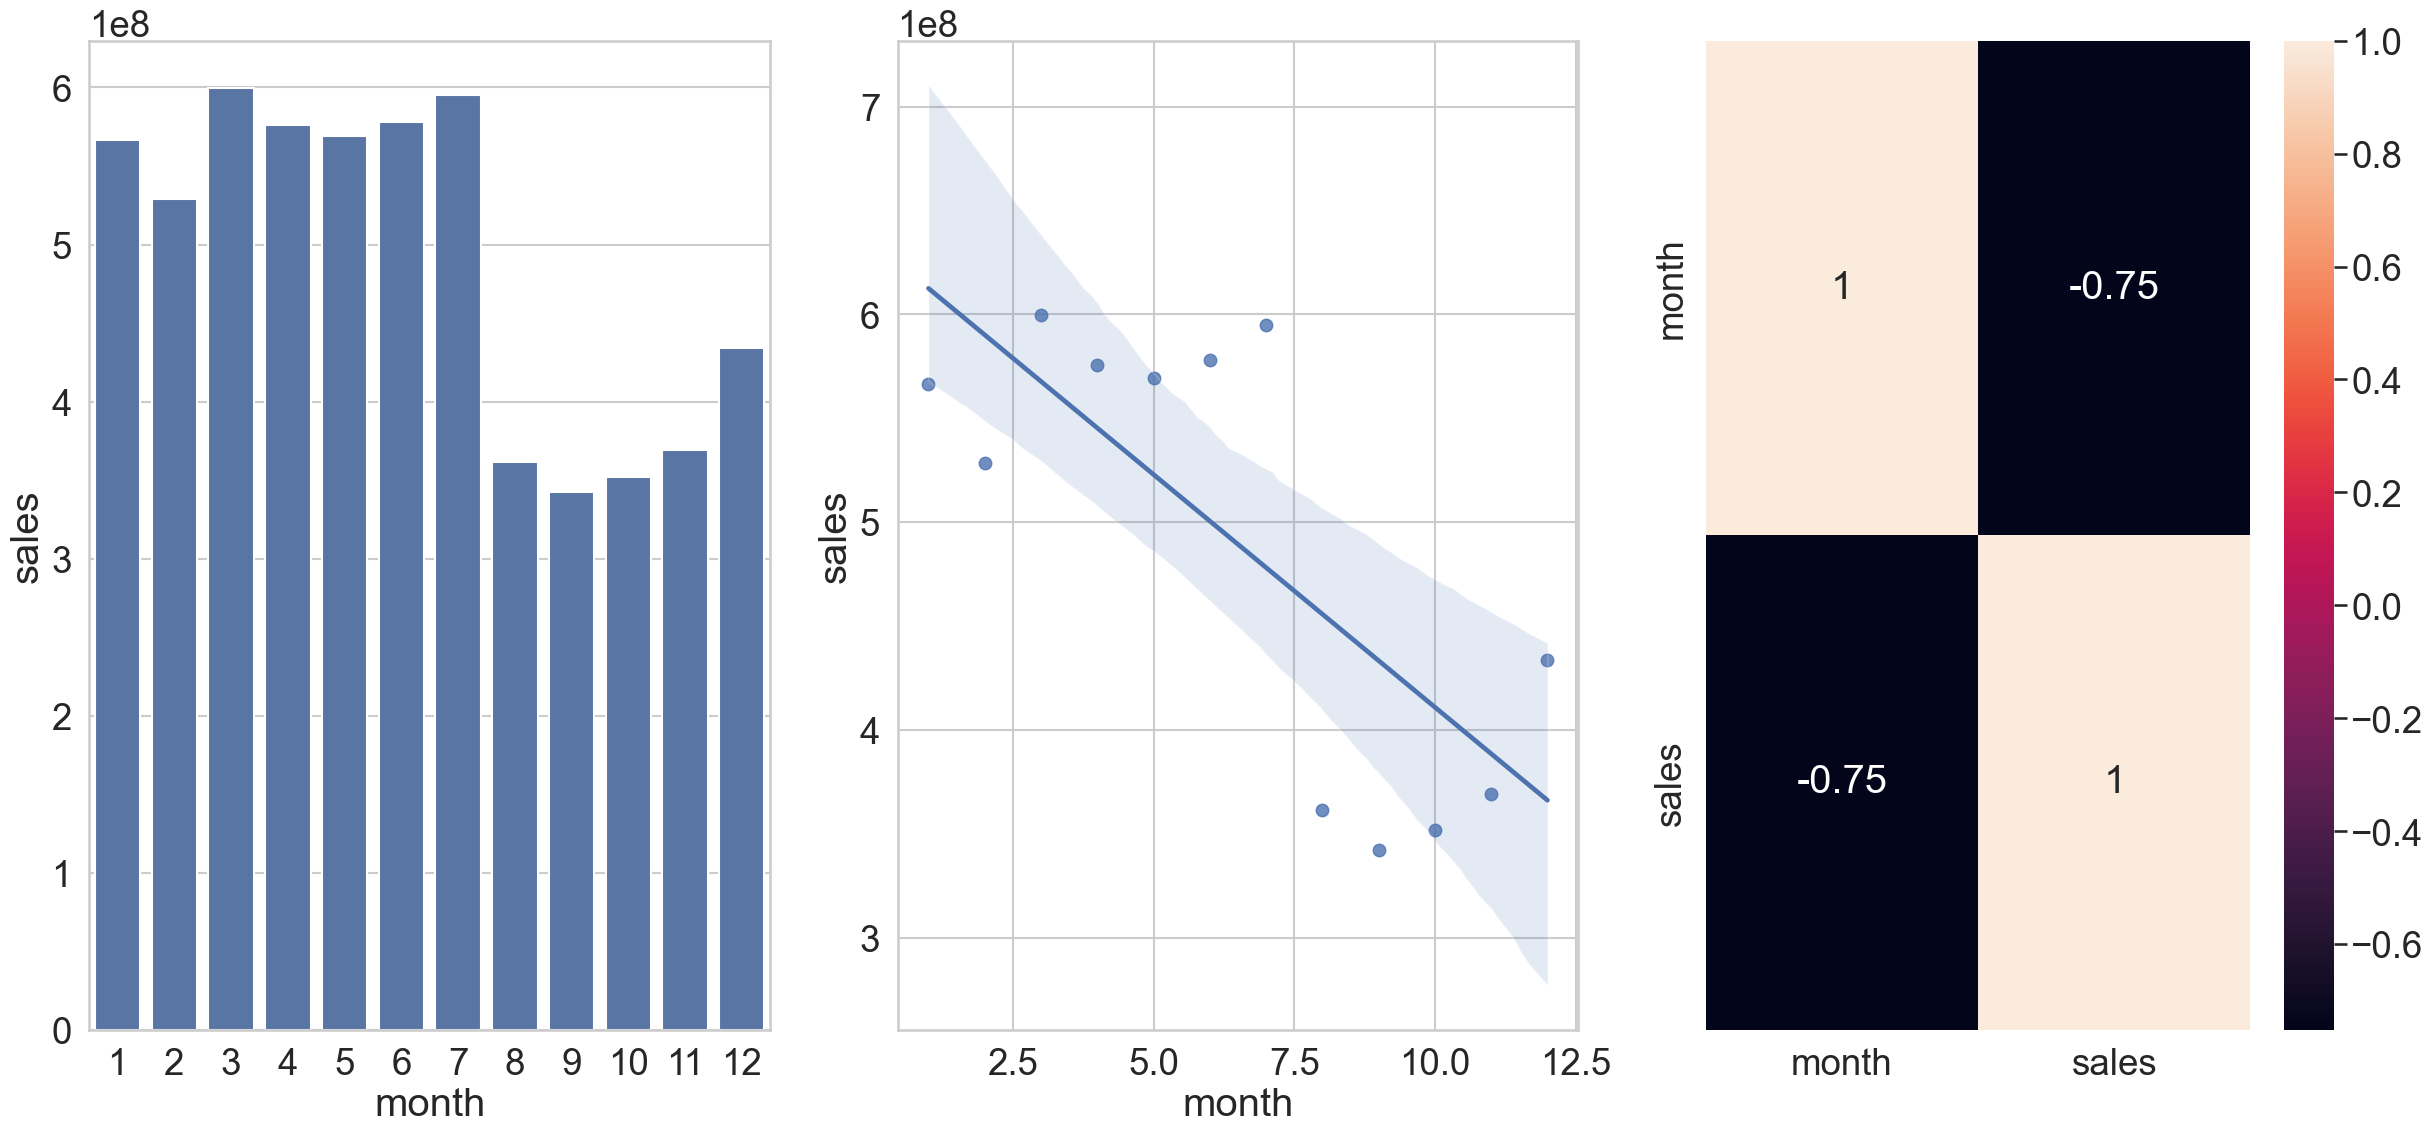

In [54]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 )
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 )
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

**FALSE HYPOTHESIS**

### H9. Stores should sell more after the 10th of each month.

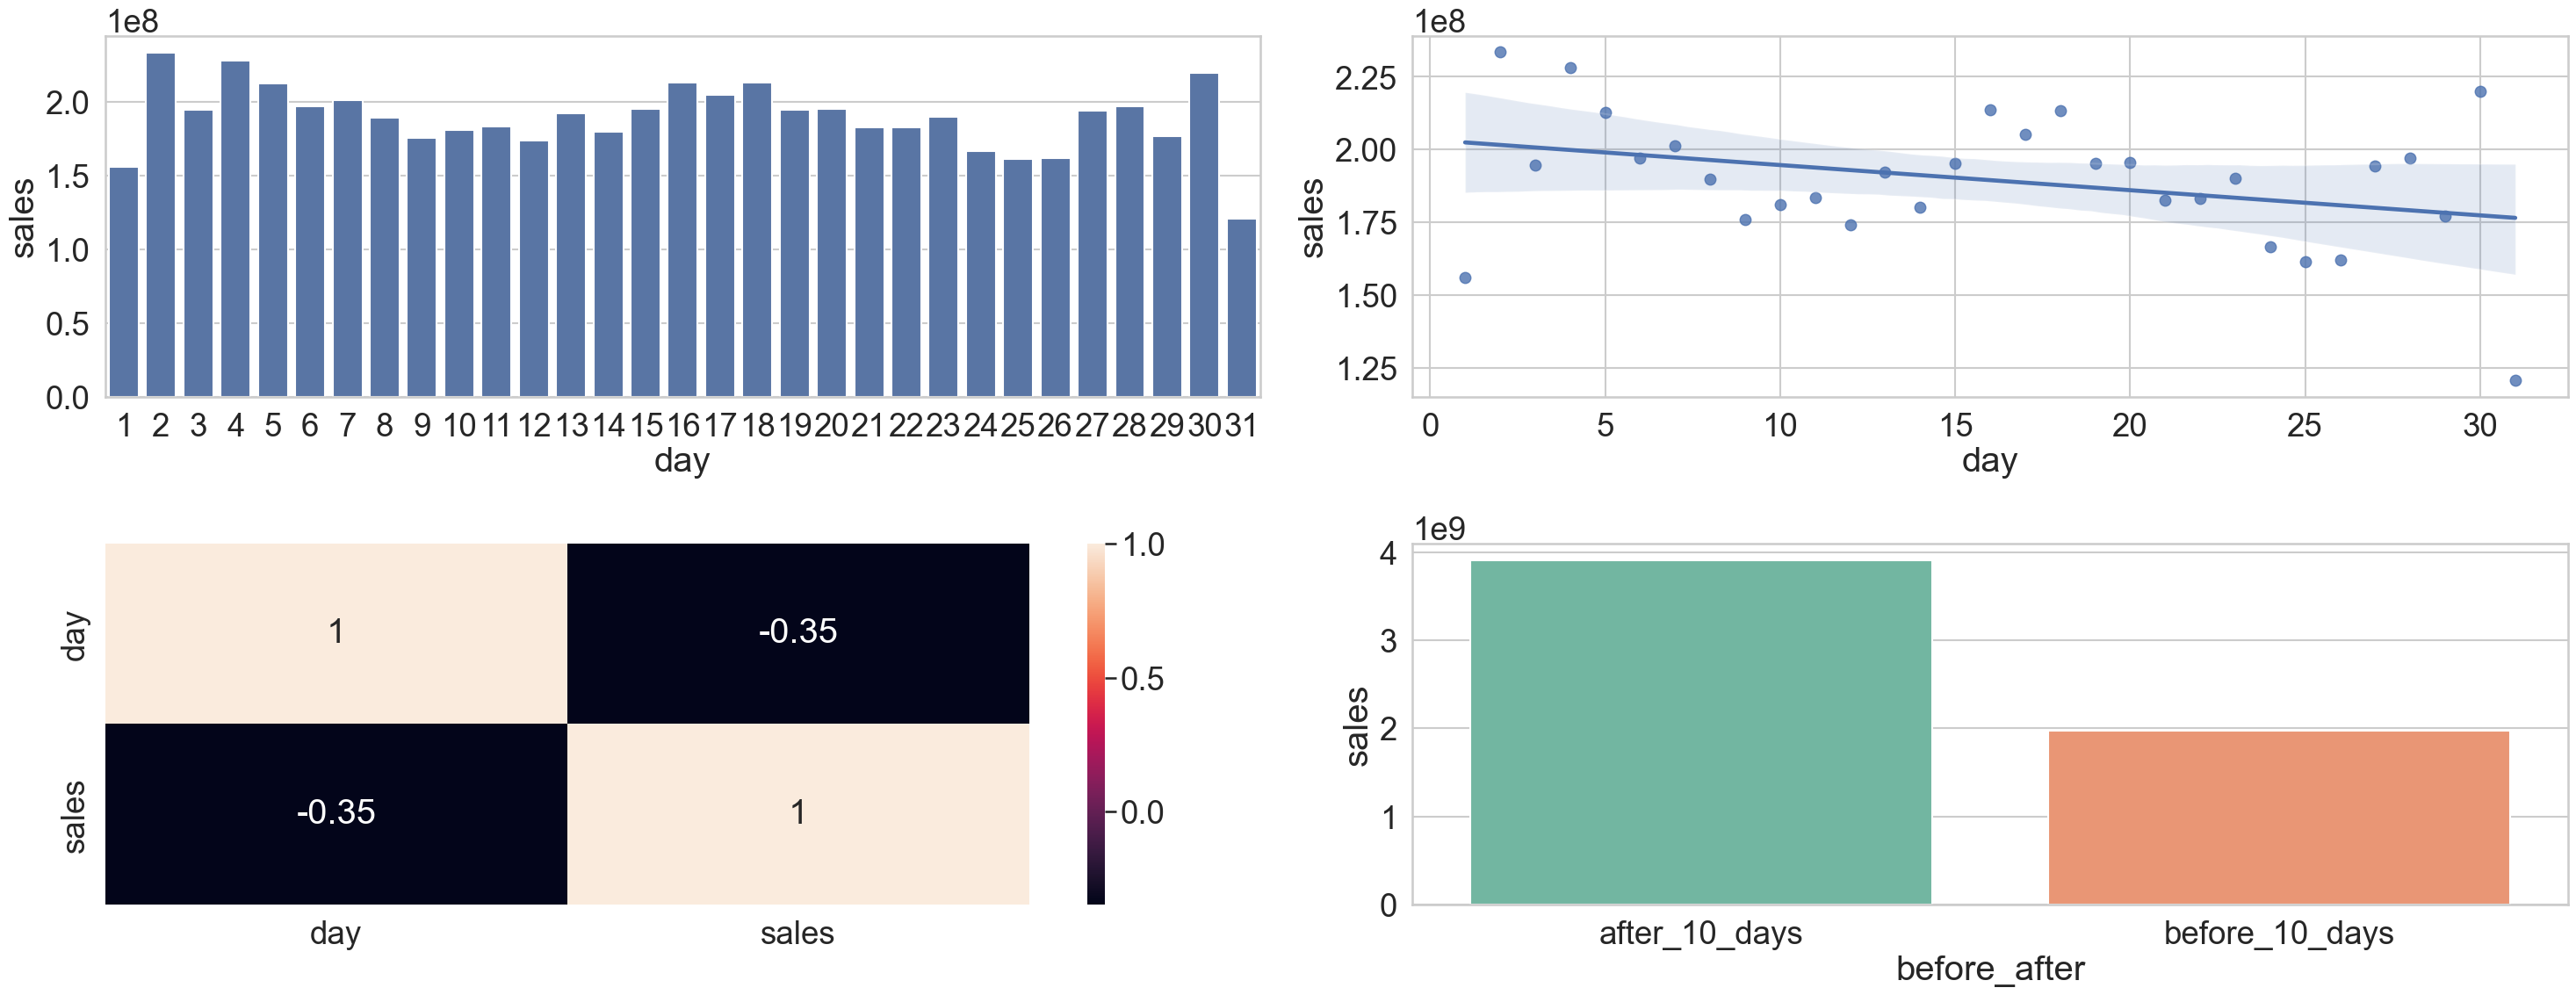

In [55]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
plt.figure(figsize=(30, 12))
plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 ,width=0.8);
plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );
plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( 
    lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']
           ].groupby( 'before_after' ).sum().reset_index()
plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 , palette='Set2');
plt.tight_layout()


**FALSE HYPOTHESIS**

### H10. Stores should sell less at weekends.

<Axes: >

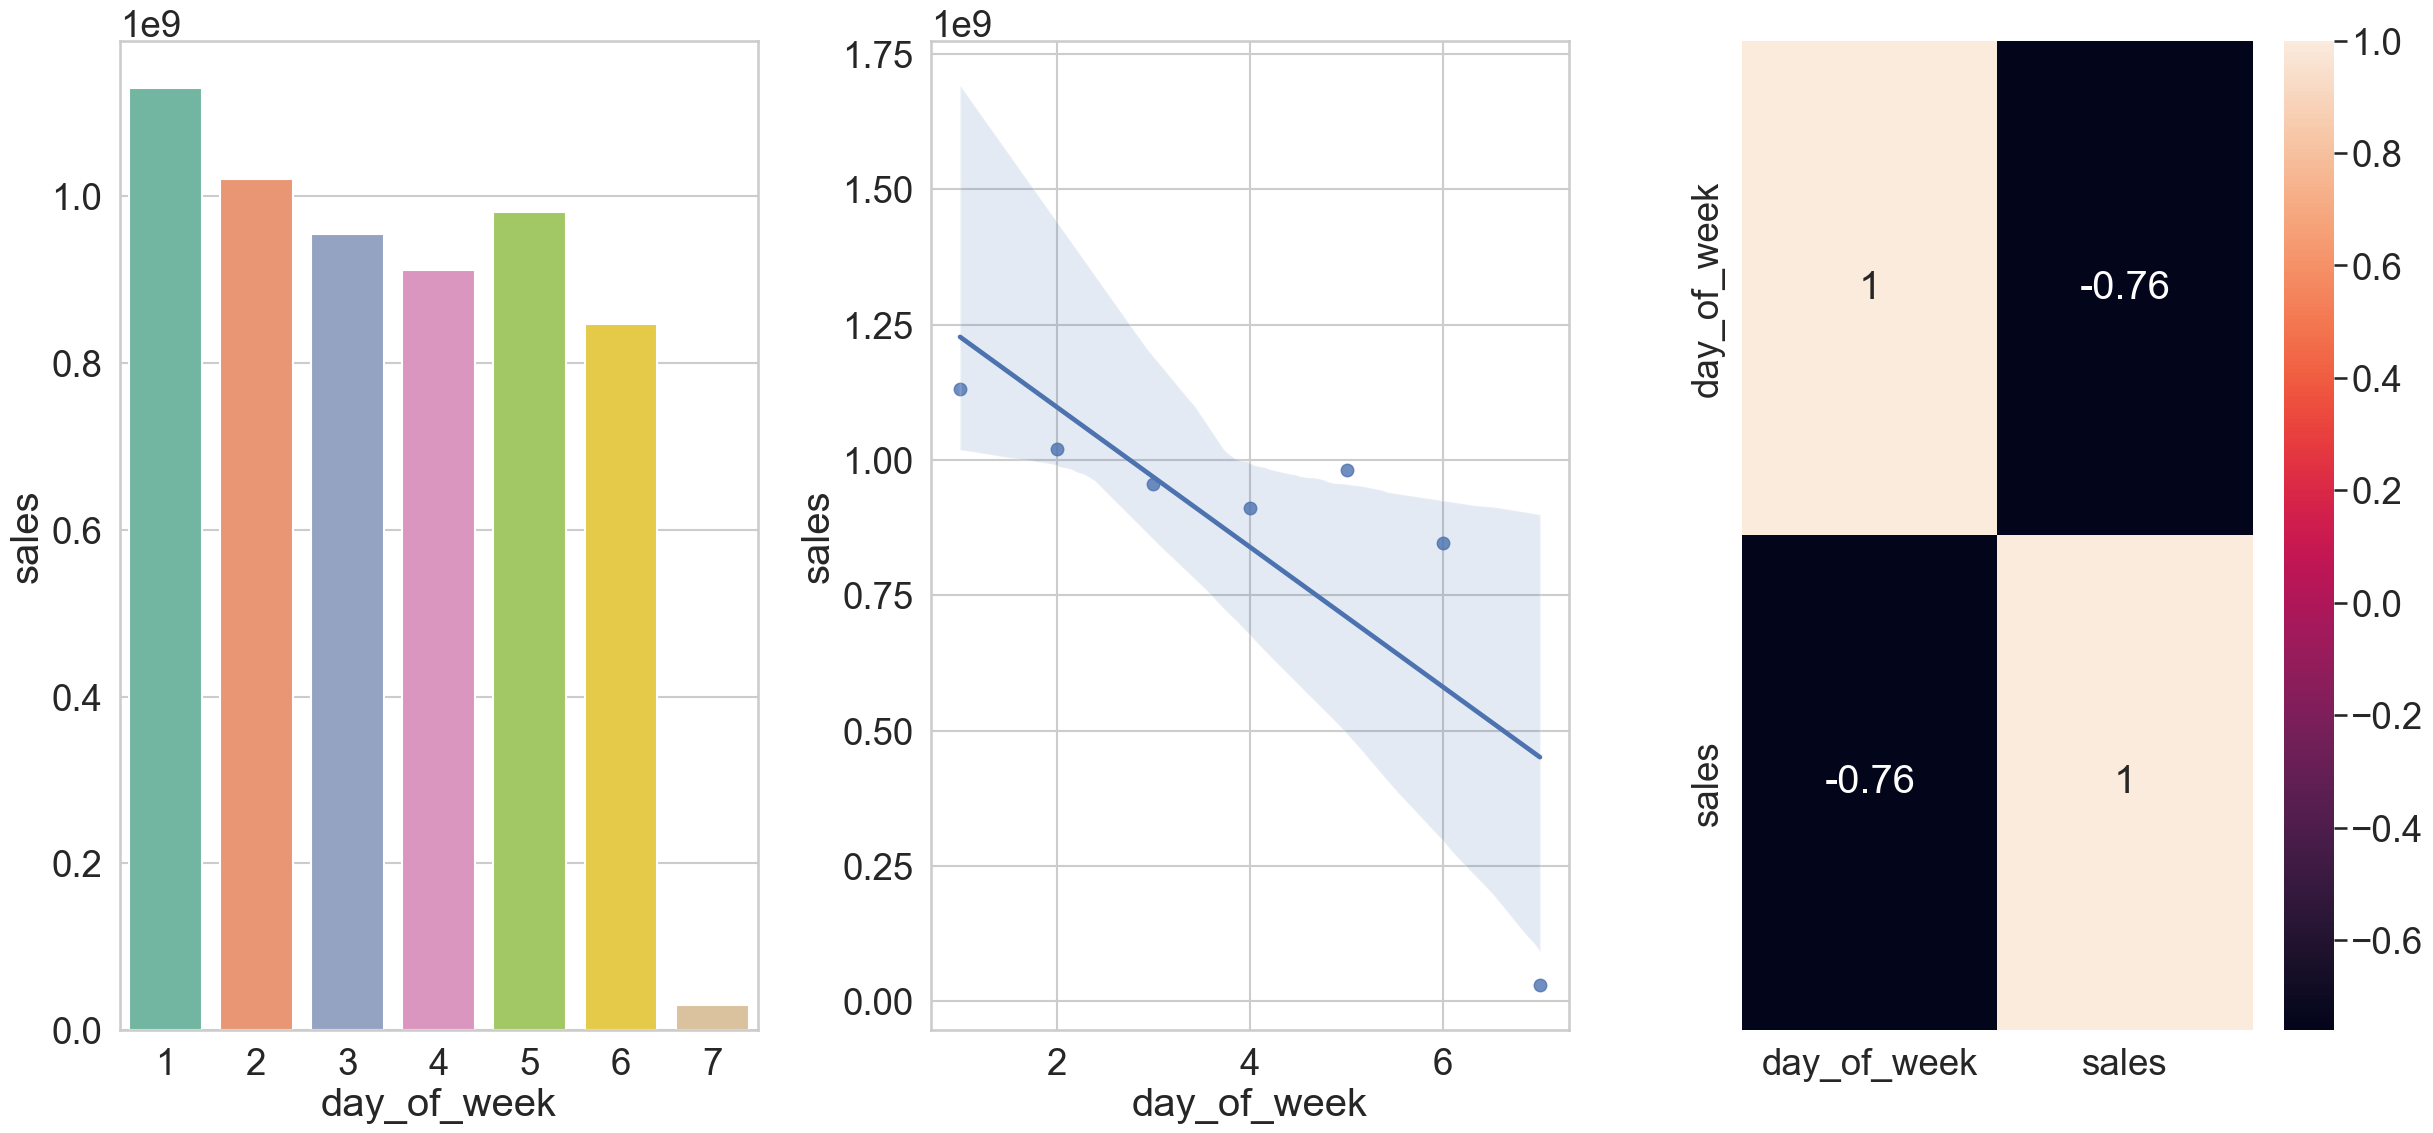

In [56]:
aux1 = df4[['day_of_week', 'sales']
            ].groupby( 'day_of_week' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 , palette='Set2')
plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 )
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

**TRUE HYPOTHESIS**

### H11. Stores should sell less during school holidays.

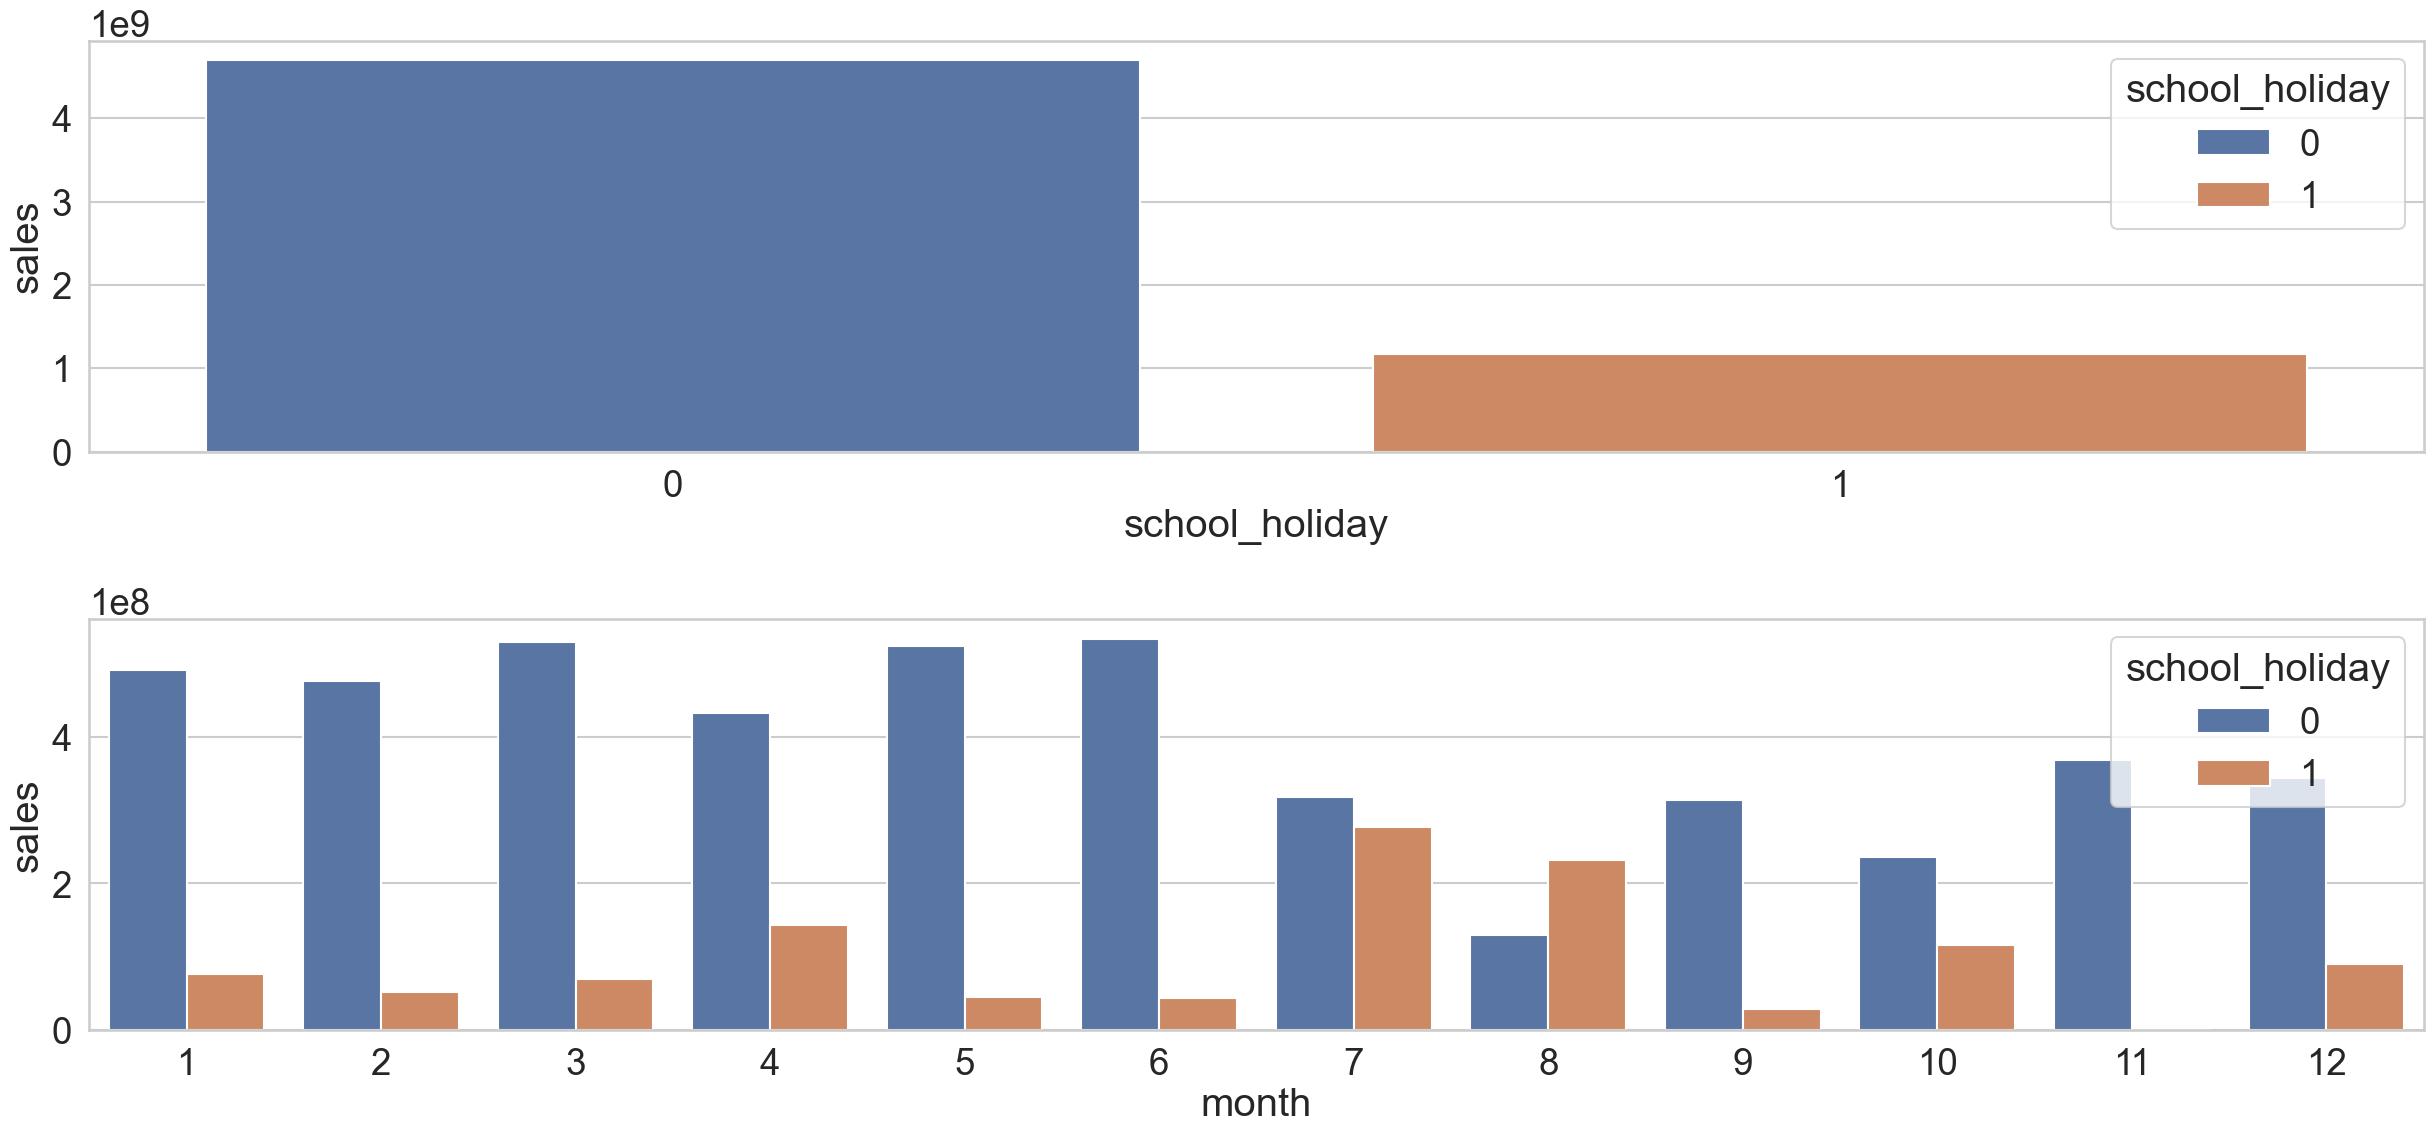

In [57]:
aux1 = df4[['school_holiday', 'sales']
           ].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 ,hue = 'school_holiday');
aux2 = df4[['month', 'school_holiday', 'sales']
           ].groupby(['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


**TRUE HYPOTHESIS**

## 4.3. Multivariate Analysis 

### 4.3.1 Numerical Attributes 

<Axes: >

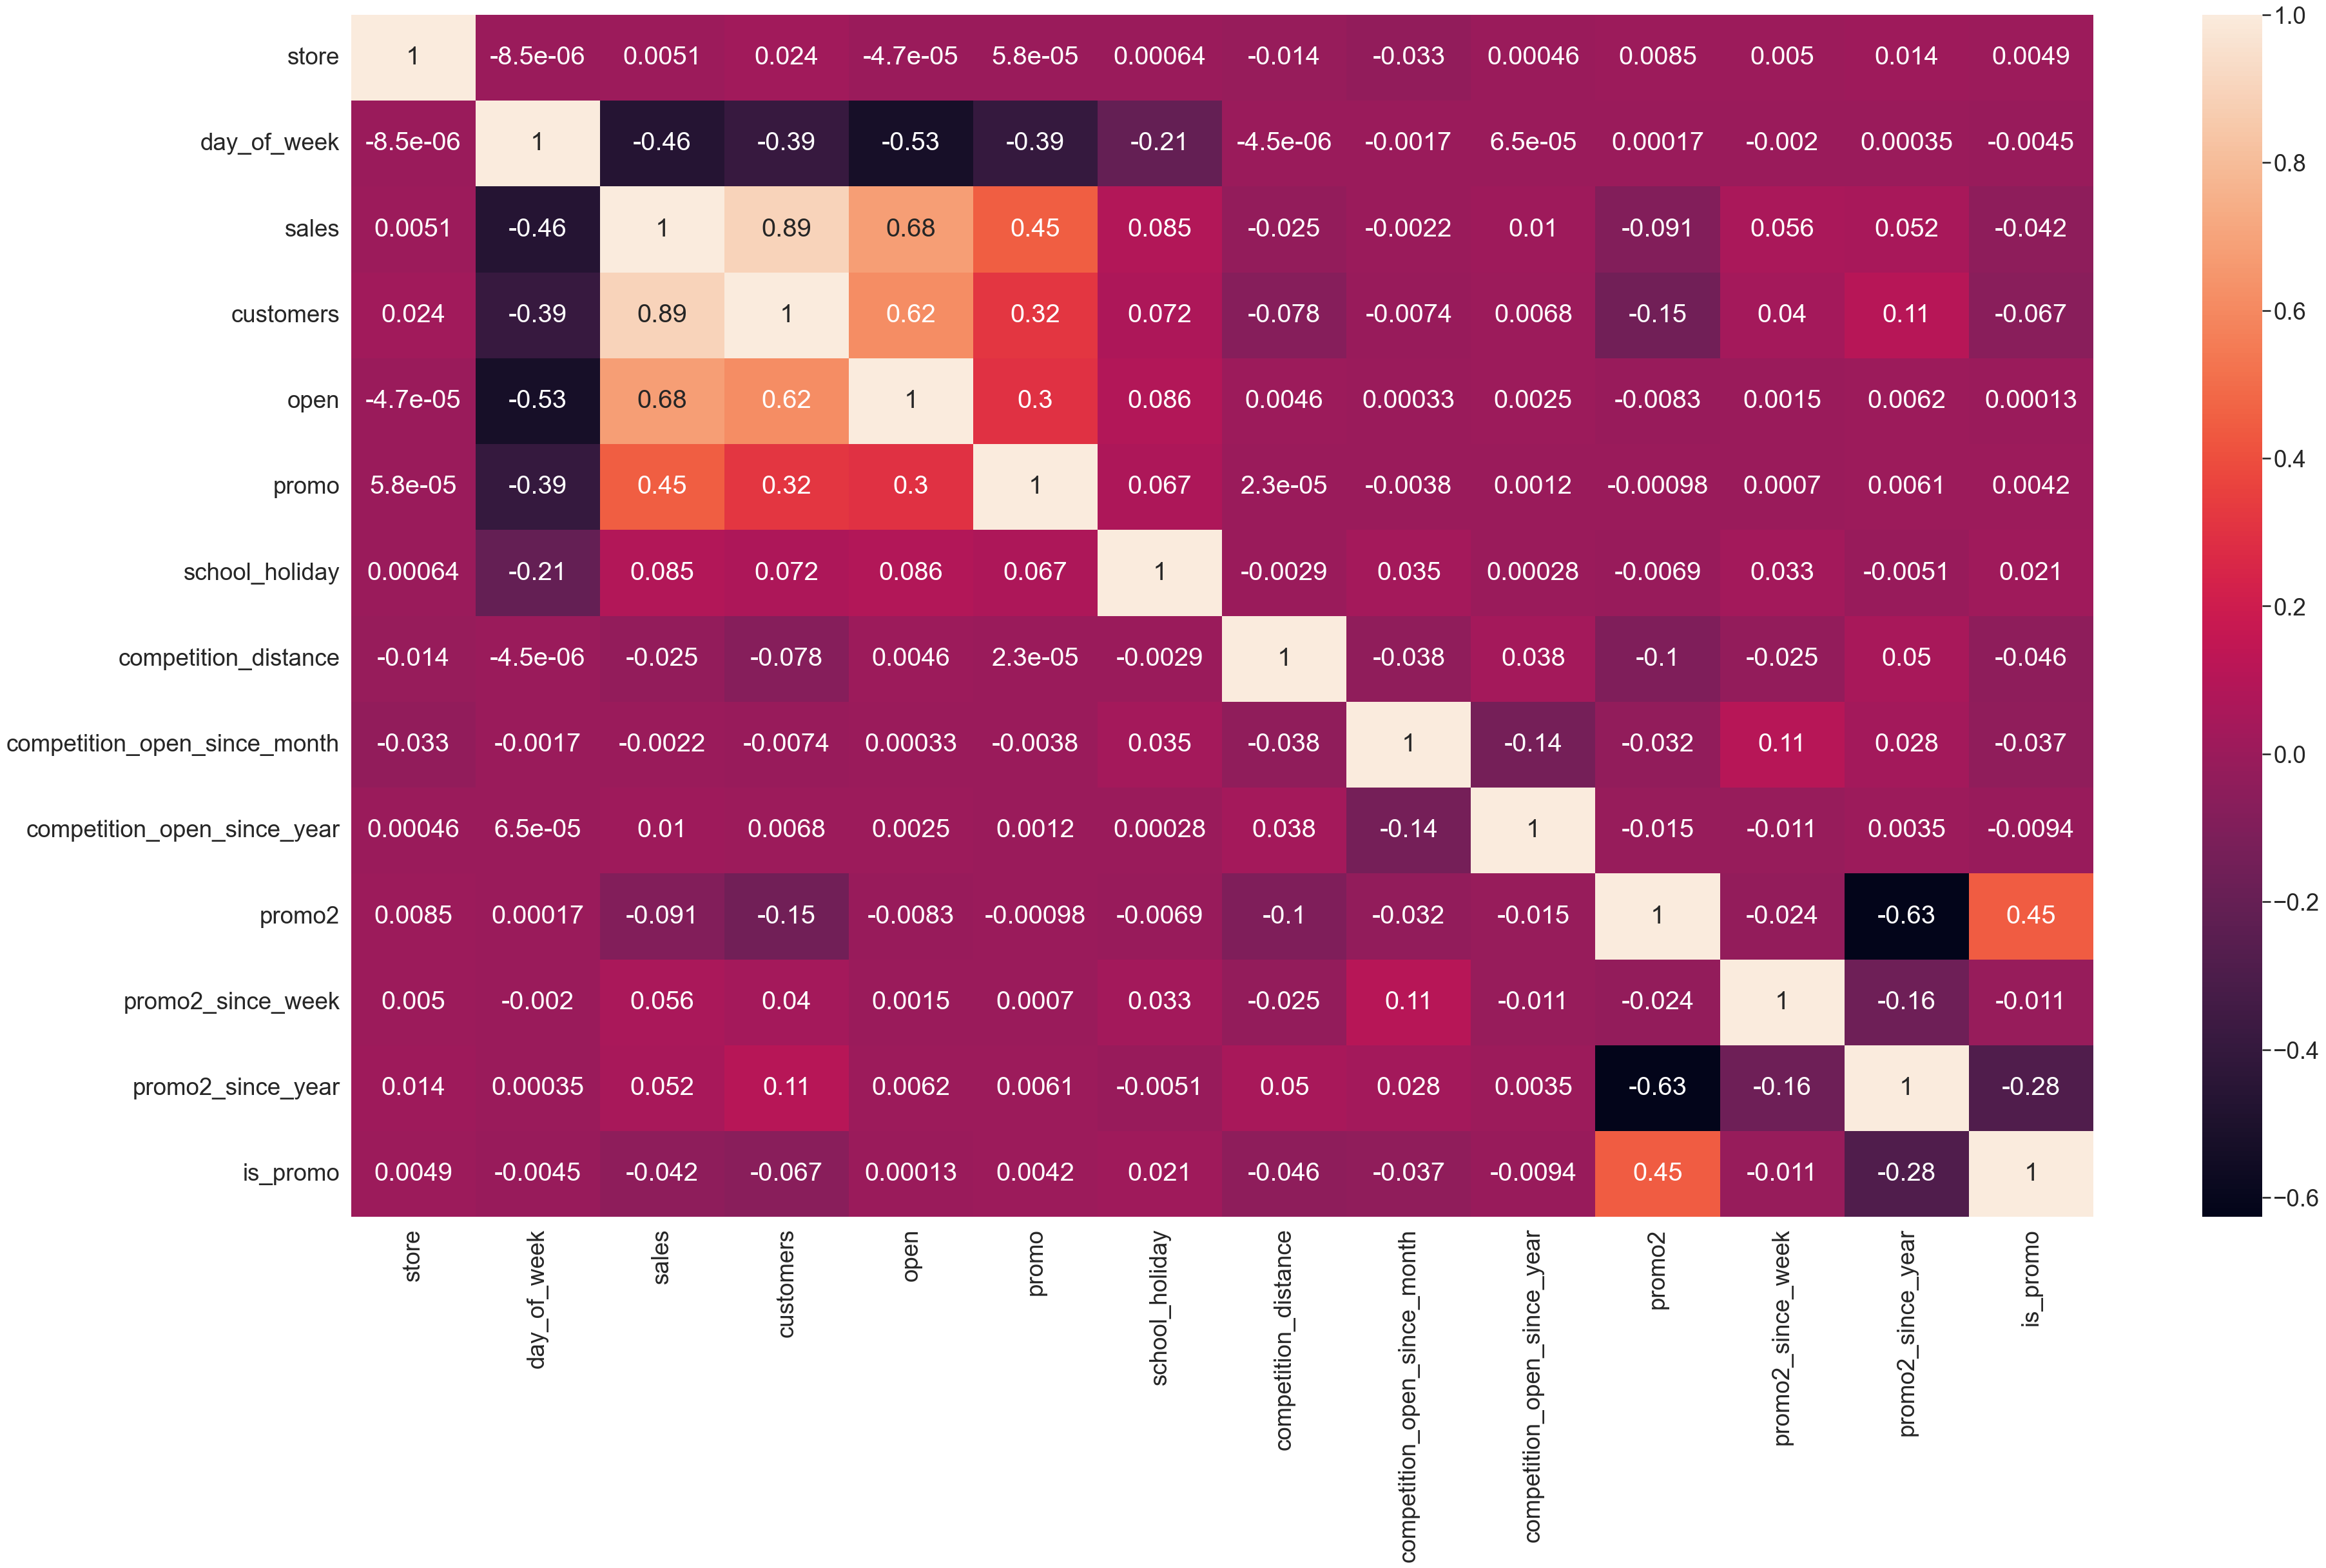

In [59]:
correlation = num_attributes.corr( method='pearson' )
plt.figure(figsize=(40,25))
sns.heatmap( correlation, annot=True )

### 4.3.2 Categorial Attributes 

<Axes: >

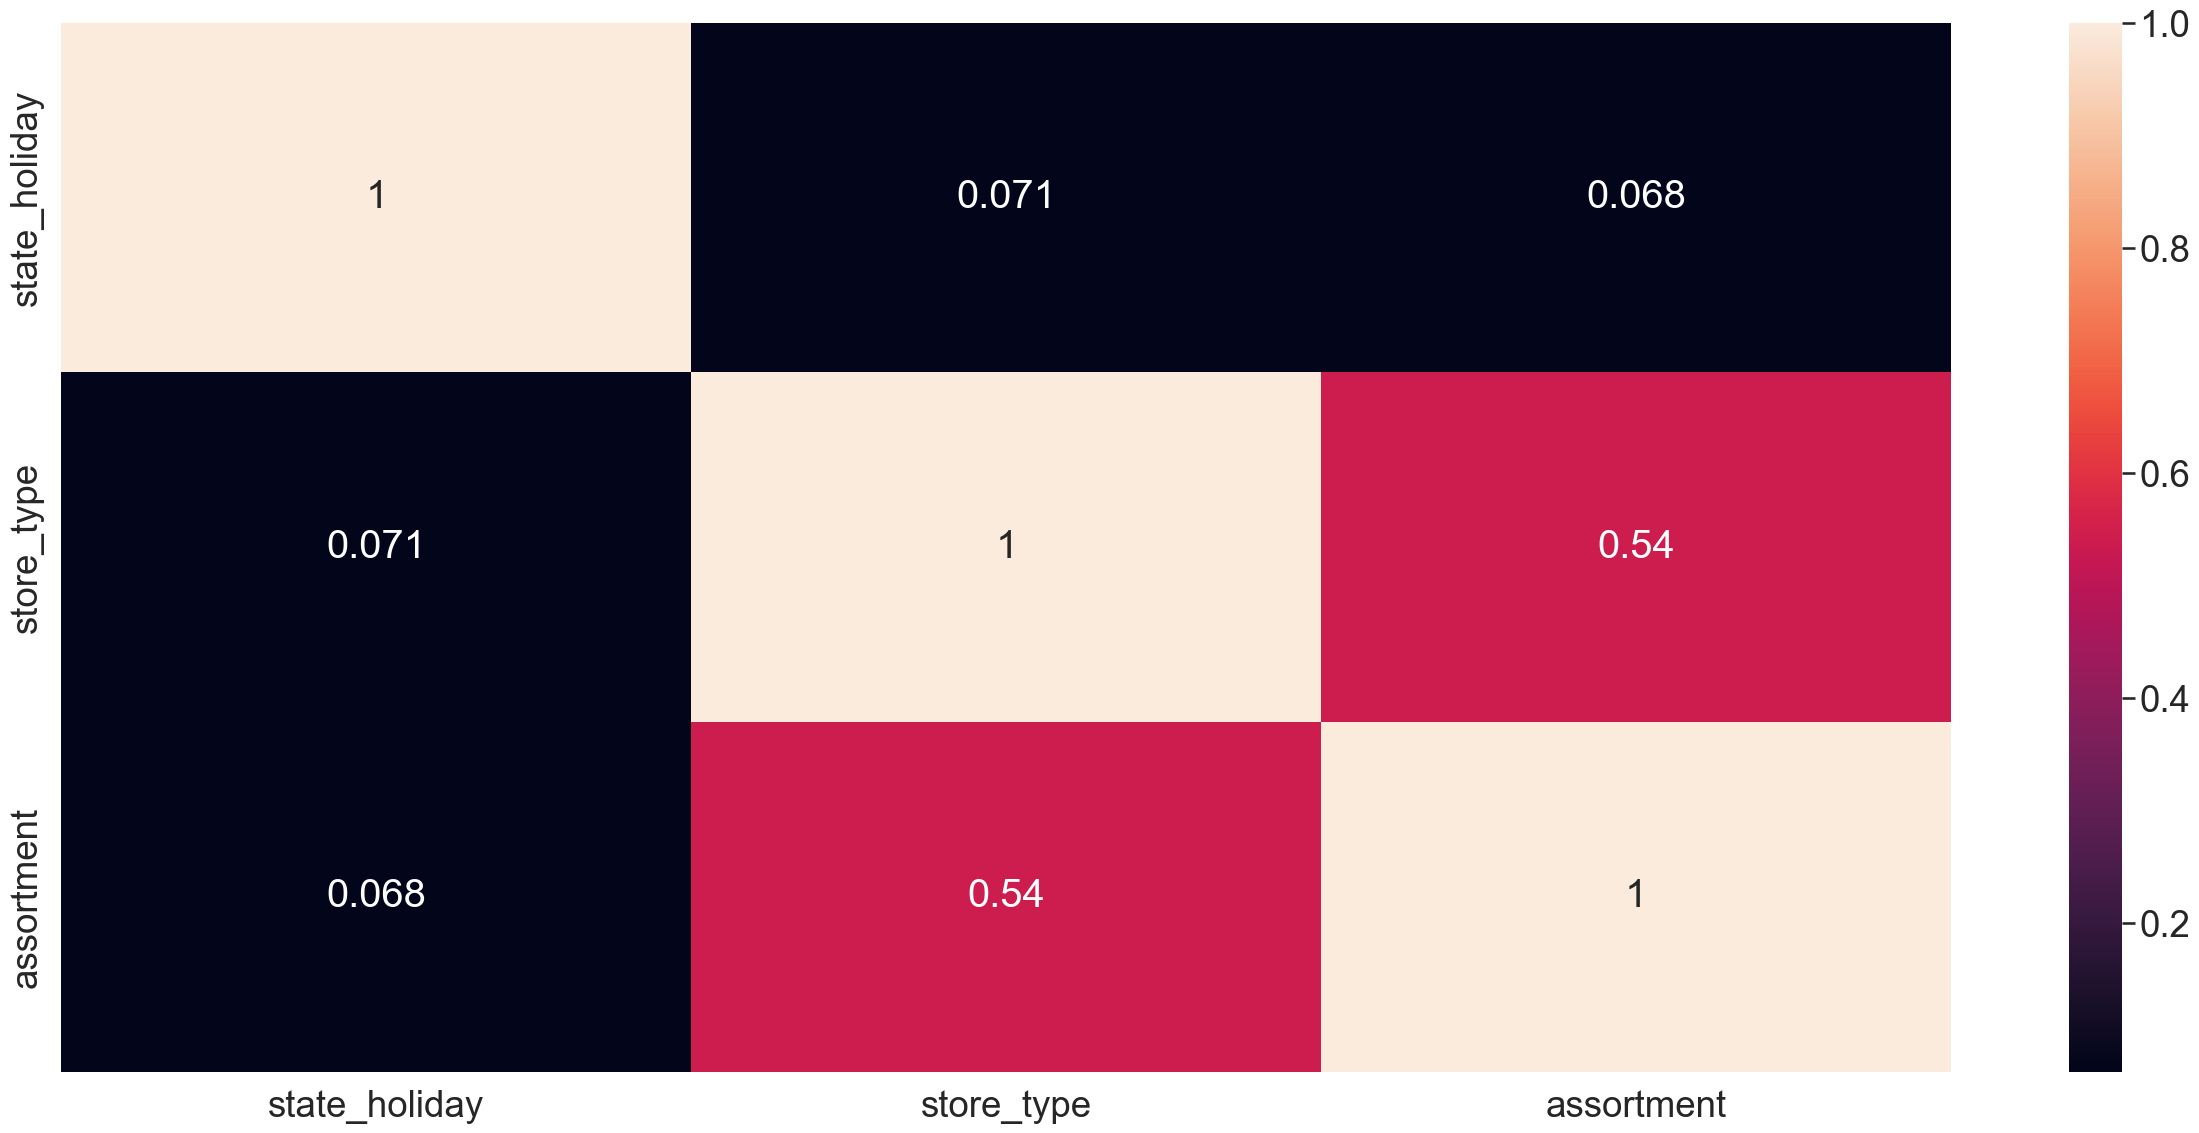

In [60]:
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                    'store_type': [a4, a5, a6],
                    'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0. DATA PREPARATION 

In [61]:
df5 = df4.copy()

## 5.1. Rescalling

In [62]:
rs = RobustScaler()
mms = MinMaxScaler()

Robust Scaler is useful when has outliers. 

<Axes: ylabel='competition_distance'>

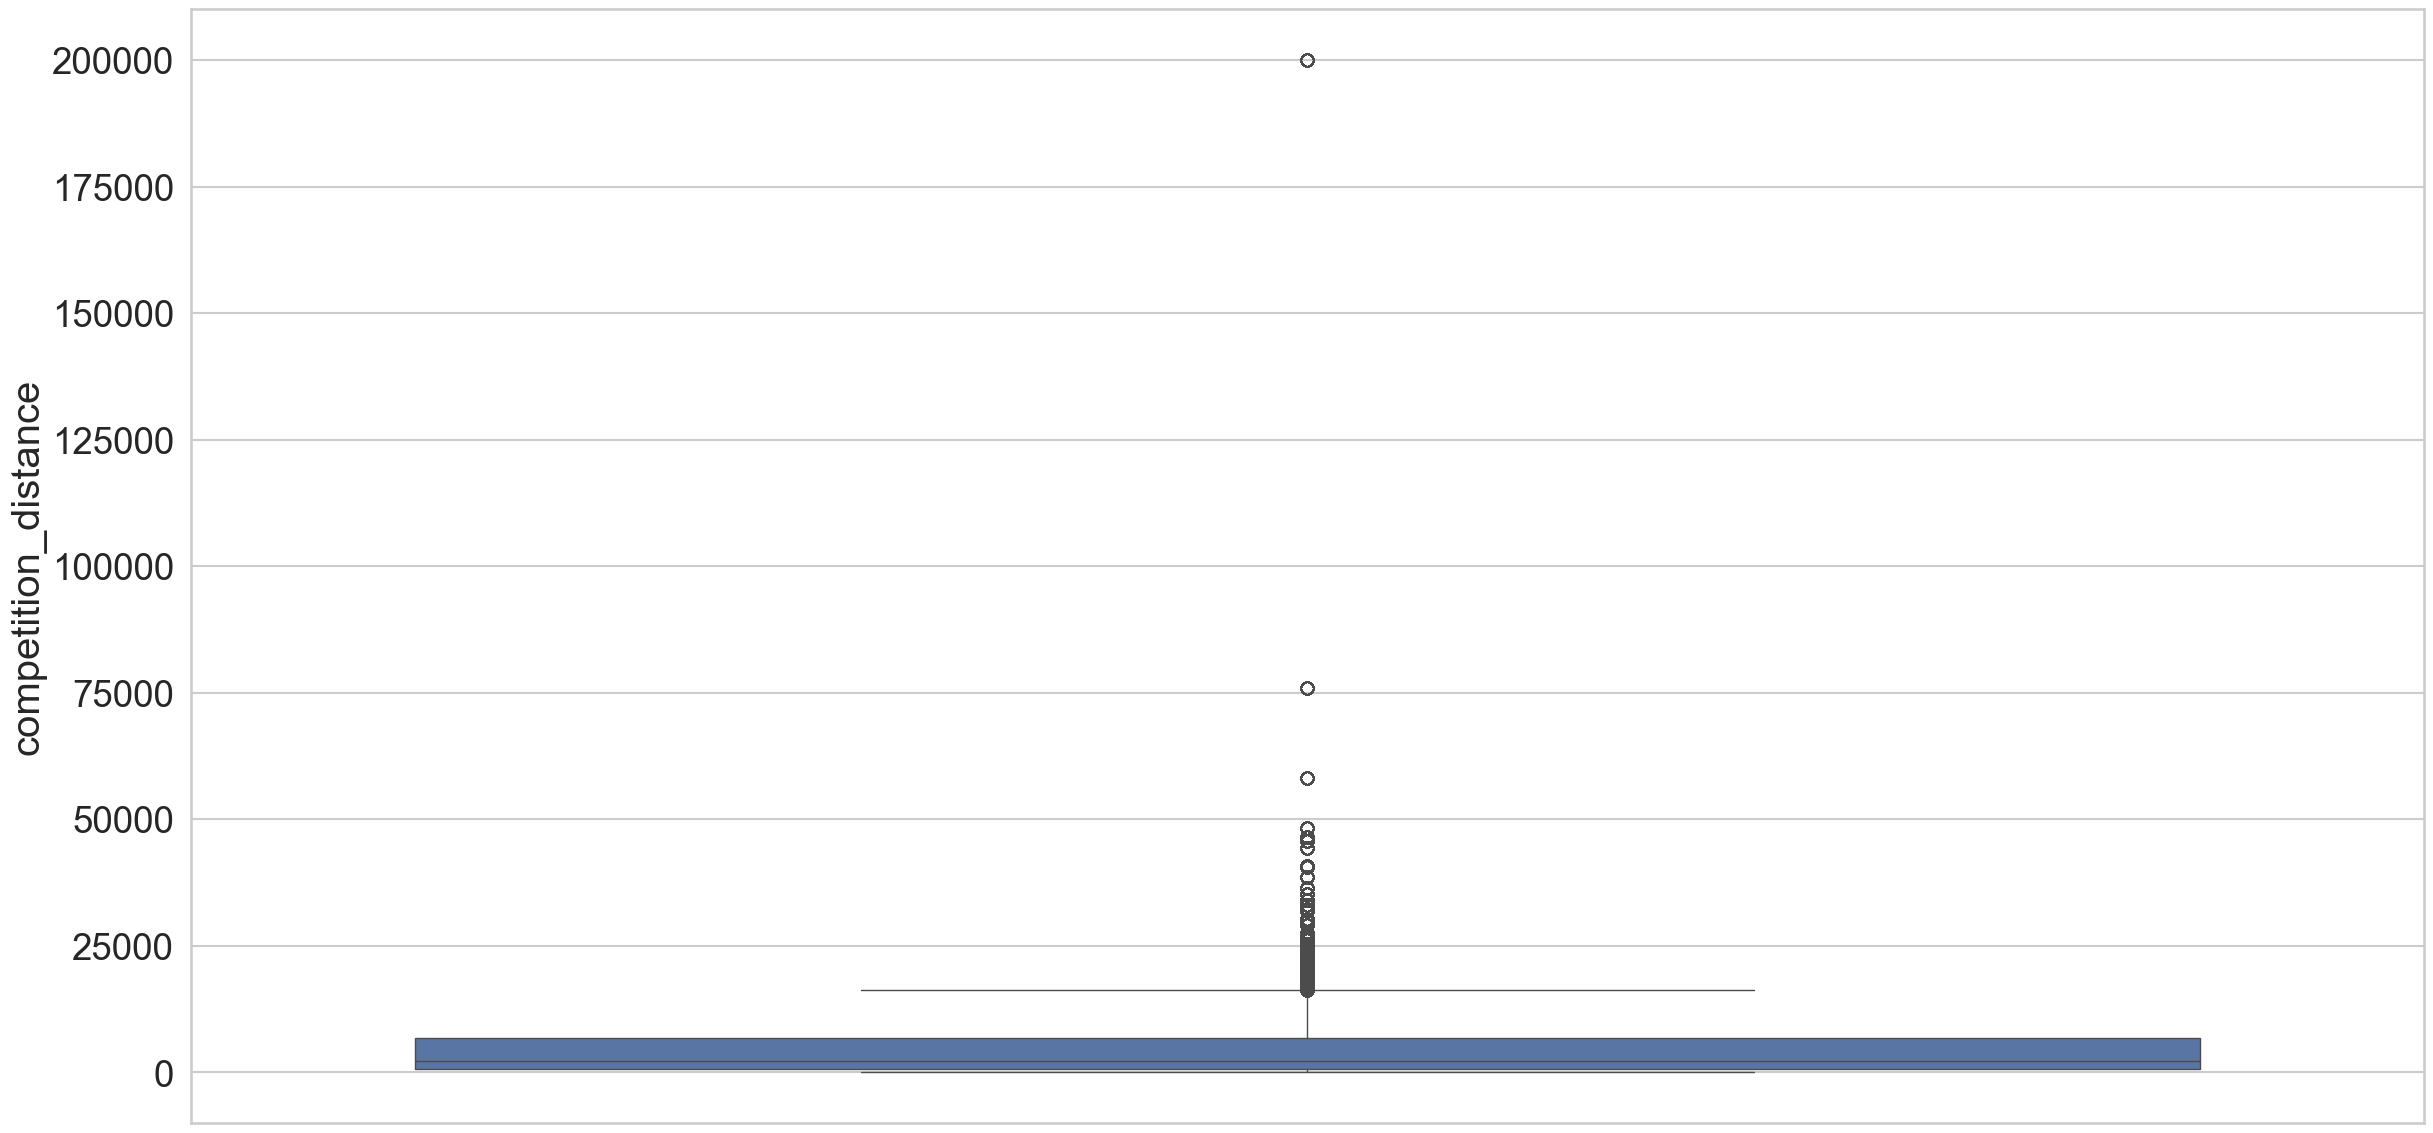

In [63]:
# Competition distance
sns.boxplot(df5['competition_distance'])

<Axes: ylabel='competition_time_month'>

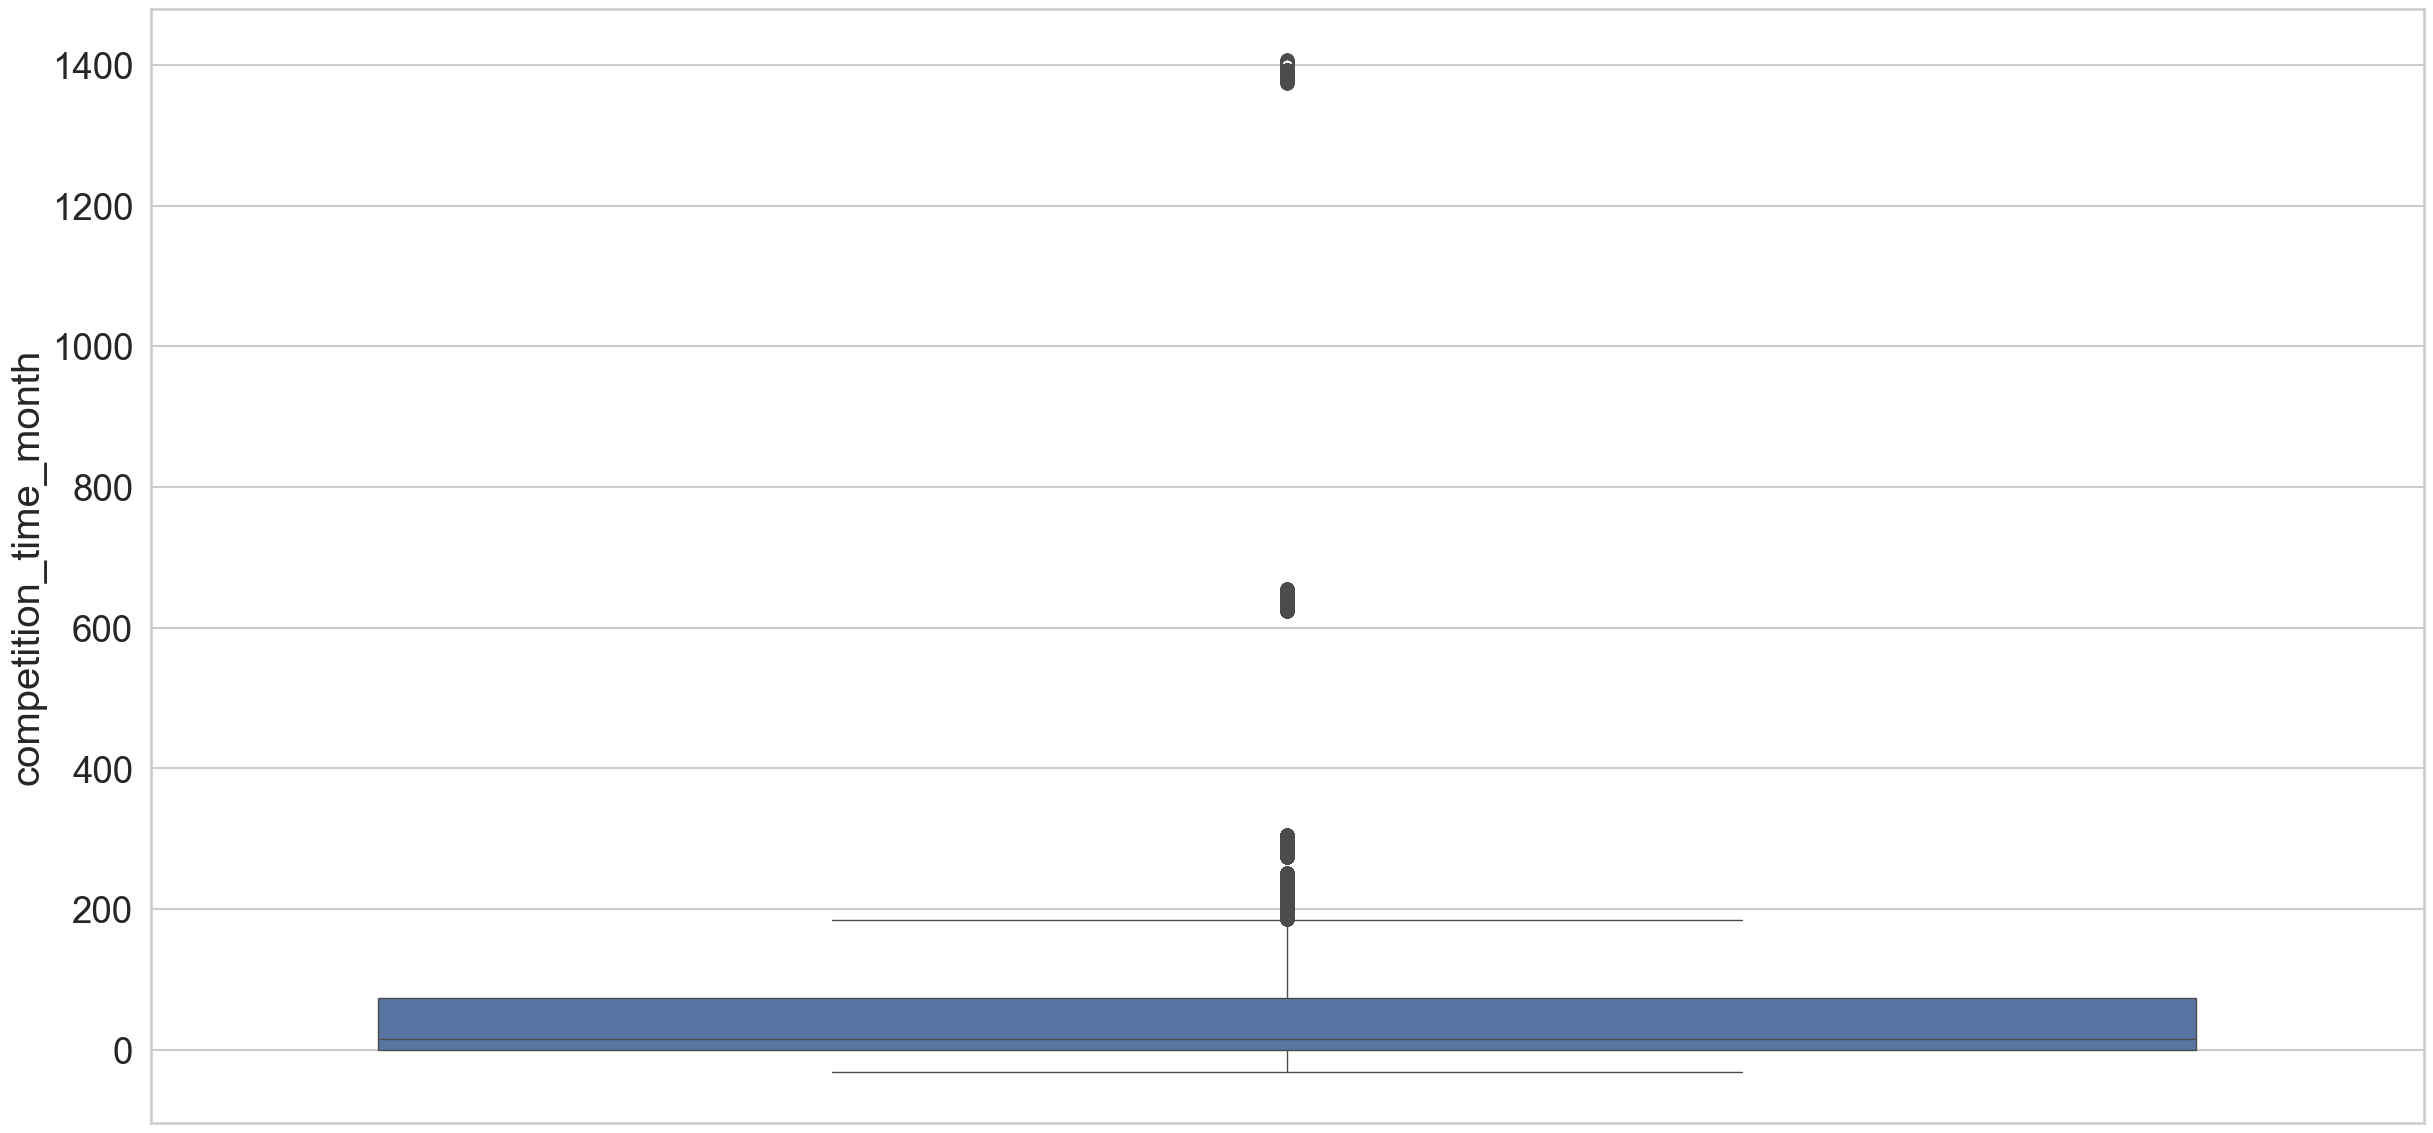

In [64]:
# Competition distance
sns.boxplot(df5['competition_time_month'])

Promo time week has less outliers, we can go with MMS

<Axes: ylabel='promo_time_week'>

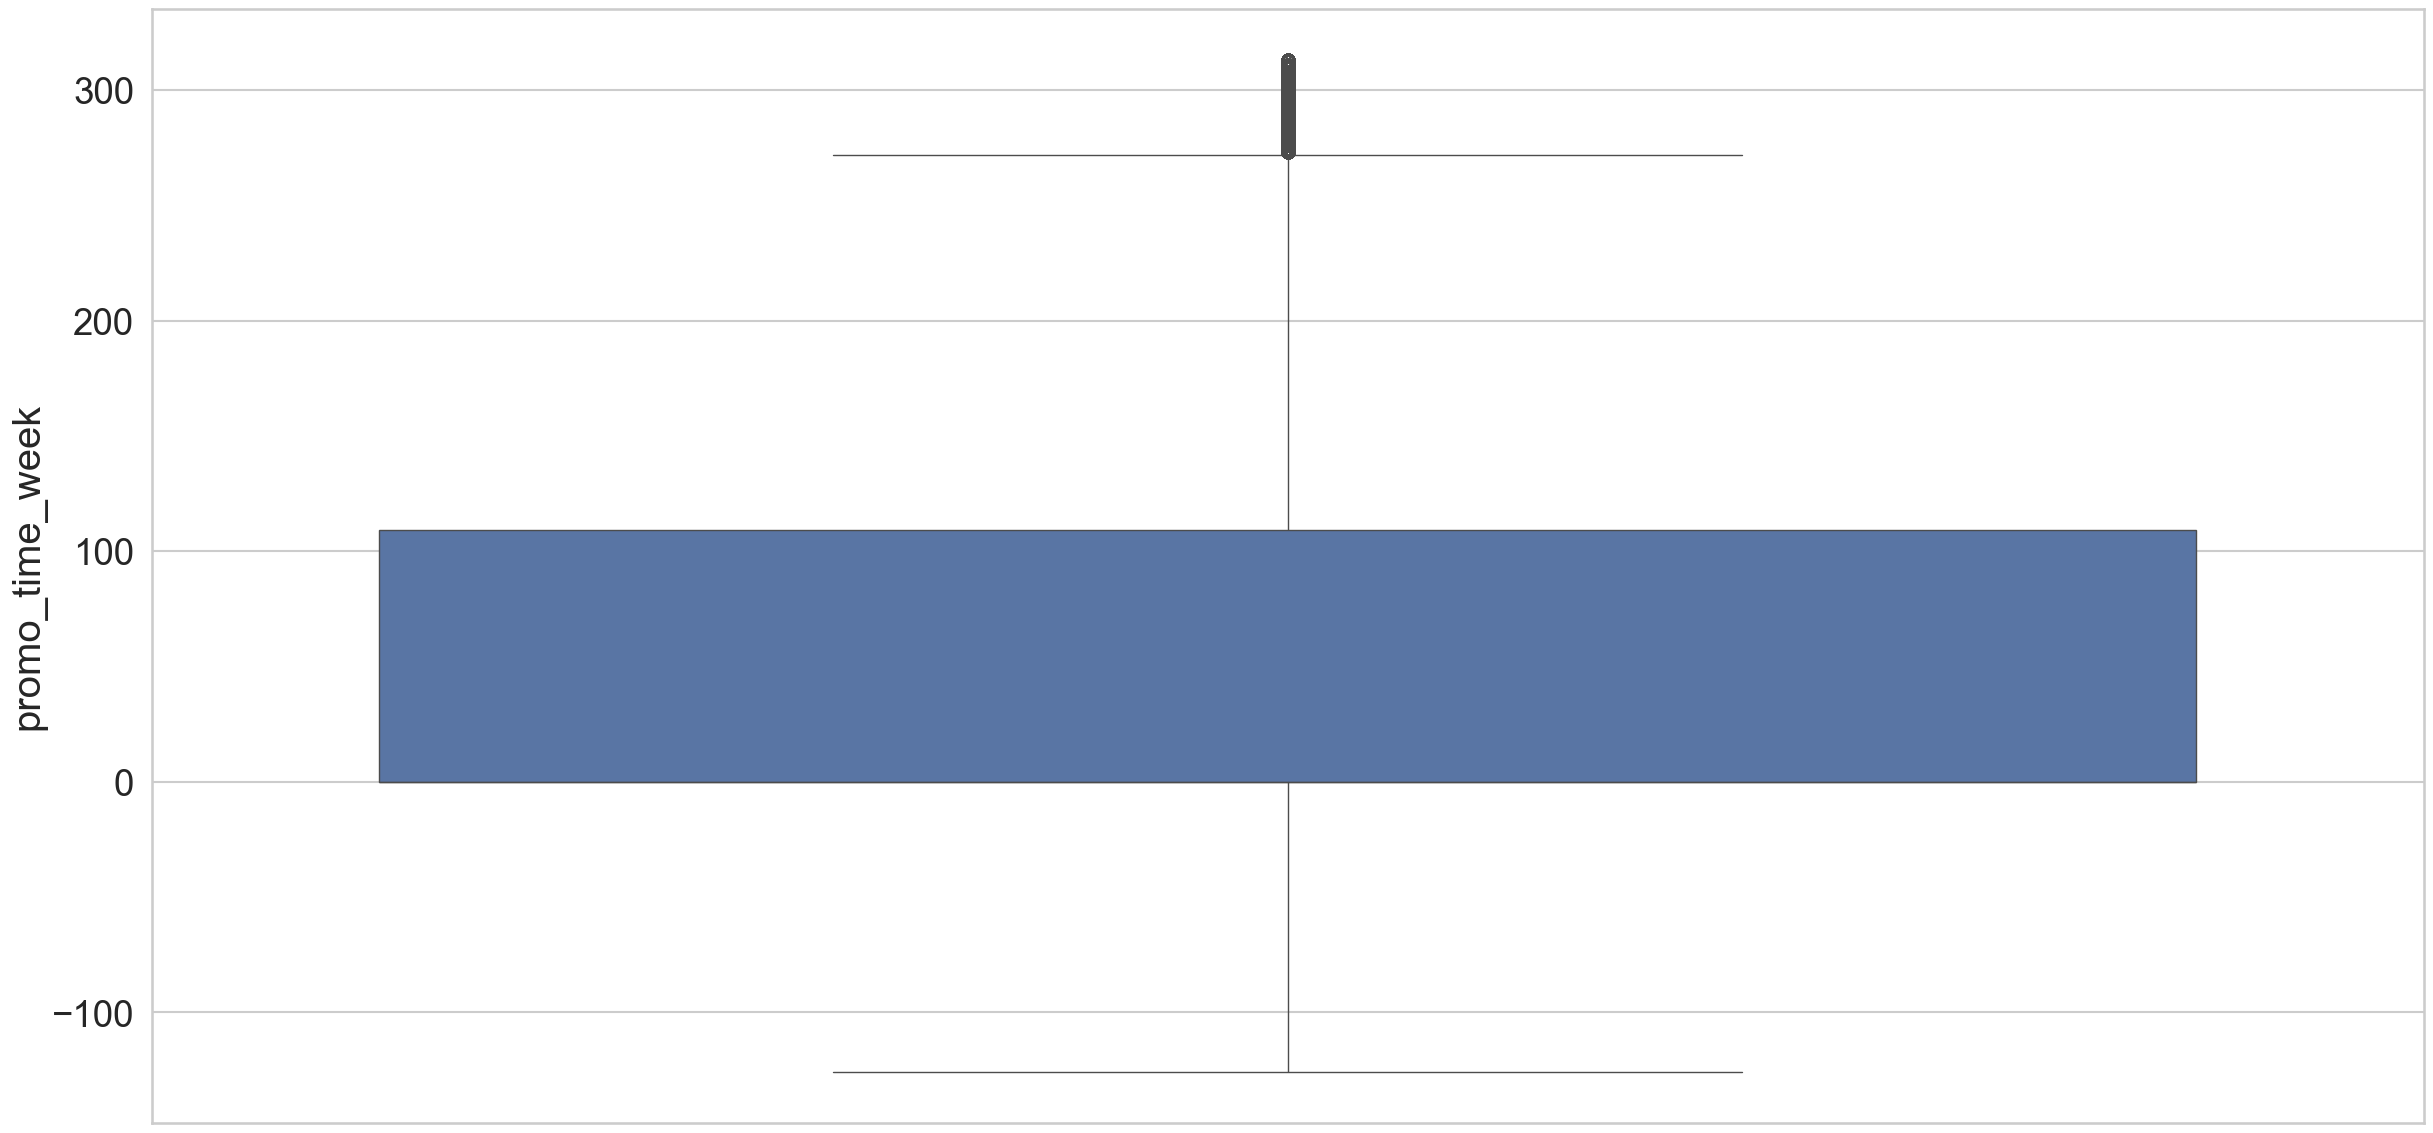

In [65]:
# Competition distance
sns.boxplot(df5['promo_time_week'])

In [66]:
# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## 5.3. Transformation

### 5.3.1. Encoding 

In [67]:
teste = df3.copy()

In [68]:
# state_holiday - One hot encoding 
df5 = pd.get_dummies(df5, columns=['state_holiday'])

# store_type - Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal encoder 
assortment_dict = {'basic' : 1, 'extra' : 2, 'extended' : 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [69]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [70]:
# This transformation was used so that the model can capture the cyclical behavior of these columns

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin( x + (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos( x + (2. * np.pi/7)))

# month 
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# 6.0. FEATURE SELECTION

In [71]:
df6 = df5.copy()

## 6.1. Train/Test Split

In [72]:
cols_drop = ['day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
df6 = df6.drop(columns=cols_drop)

In [73]:
# Find 6 weeks before to split train and test
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days= 6*7)

Timestamp('2015-06-19 00:00:00')

In [74]:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Train Min Date: {}'.format( X_train['date'].min() ) )
print( 'Train Max Date: {}'.format( X_train['date'].max() ) )

print( 'Test Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Train Min Date: 2013-01-01 00:00:00
Train Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Select features with Boruta

In [ ]:
# training and test dataset for Boruta
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, 
                  random_state=42 ).fit(X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta 

In [240]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

## 6.3. Manual Feature Selection    

In [76]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos']

feats_to_add = ['date', 'sales']

cols_full = cols_selected_boruta.copy()
cols_full.extend(feats_to_add)

# 7.0. MACHINE LEARNING MODELING

In [77]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

X_training = X_train[cols_full]

## 7.1. Average Model 

In [104]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean(
).reset_index().rename(columns={'sales': 'predictions'} )

aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', 
                           np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result

Model Name          MAE      MAPE         RMSE
0  Average Model  1354.800353  0.455051  1835.135542

## 7.2. Linear Regression Model 

In [105]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test 
                                                    ), np.expm1(yhat_lr ) )
lr_result

Model Name          MAE      MAPE         RMSE
0  Linear Regression  1871.073999  0.293023  2678.087444

### 7.2.1. Linear Regression Model - Cross Validation

In [106]:
lr_result_cv = cross_validation( X_training, 5, 'Linear Regression', lr,verbose=False )
lr_result_cv

Model Name             MAE CV       MAPE CV             RMSE CV
0  Linear Regression  2081.23 +/- 293.0  0.3 +/- 0.02  2952.08 +/- 464.59

## 7.3. Linear Regression Regularized Model - Lasso

In [107]:
 # model
lrr = Lasso( alpha=0.0001 ).fit( x_train, y_train )
# prediction
yhat_lrr = lrr.predict( x_test )
# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

c:\Users\bruni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e+04, tolerance: 1.455e+01
  model = cd_fast.enet_coordinate_descent(


Model Name          MAE      MAPE         RMSE
0  Linear Regression - Lasso  1871.278754  0.292461  2680.995457

### 7.3.1. Lasso - Cross Validation

In [108]:
lrr_result_cv = cross_validation( X_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

c:\Users\bruni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.578e+04, tolerance: 1.117e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\bruni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e+04, tolerance: 1.194e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\bruni\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Model Name              MAE CV       MAPE CV             RMSE CV
0      Lasso  2081.57 +/- 297.29  0.3 +/- 0.02  2956.24 +/- 469.19

## 7.4. Random Forest Regressor 

In [109]:
 # model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train )
# prediction
yhat_rf = rf.predict( x_test )
# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

Model Name         MAE      MAPE         RMSE
0  Random Forest Regressor  704.506334  0.104936  1036.749598

### 7.4.1. Random Forest Regressor - Cross Validation

In [110]:
rf_result_cv = cross_validation( X_training, 5, 'Random Forest Regressor', rf,verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


Model Name             MAE CV        MAPE CV  \
0  Random Forest Regressor  844.28 +/- 225.93  0.12 +/- 0.02   

              RMSE CV  
0  1265.07 +/- 332.13

## 7.5. XGBoost Regressor

In [111]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
n_estimators=100,
eta=0.01,
max_depth=10,
subsample=0.7,
colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )
# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result


c:\Users\bruni\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:17:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


Model Name          MAE      MAPE         RMSE
0  XGBoost Regressor  1691.858364  0.251634  2472.093509

### 7.5.1. XGBoost Regressor - Cross Validation

In [112]:
xgb_result_cv = cross_validation( X_training, 5, 'XGBoost Regressor',model_xgb, verbose=True )
xgb_result_cv



KFold Number: 5


c:\Users\bruni\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:18:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



KFold Number: 4


c:\Users\bruni\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:18:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



KFold Number: 3


c:\Users\bruni\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:18:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



KFold Number: 2


c:\Users\bruni\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:18:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)



KFold Number: 1


c:\Users\bruni\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:18:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytee" } are not used.

  warnings.warn(smsg, UserWarning)


Model Name              MAE CV        MAPE CV             RMSE CV
0  XGBoost Regressor  1859.62 +/- 290.19  0.25 +/- 0.01  2684.18 +/- 429.35

## 7.6. Compare Model's Performance 

### 7.6.1. Single Performance 

In [115]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result,rf_result, xgb_result] )
modelling_result.sort_values( 'MAPE' )

Model Name          MAE      MAPE         RMSE
0    Random Forest Regressor   704.506334  0.104936  1036.749598
0          XGBoost Regressor  1691.858364  0.251634  2472.093509
0  Linear Regression - Lasso  1871.278754  0.292461  2680.995457
0          Linear Regression  1871.073999  0.293023  2678.087444
0              Average Model  1354.800353  0.455051  1835.135542

### 7.6.2. Real Performance - Cross Validation

In [120]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv,xgb_result_cv] )
modelling_result_cv.sort_values( 'MAPE CV' )

Model Name              MAE CV        MAPE CV  \
0  Random Forest Regressor   844.28 +/- 225.93  0.12 +/- 0.02   
0        XGBoost Regressor  1859.62 +/- 290.19  0.25 +/- 0.01   
0        Linear Regression   2081.23 +/- 293.0   0.3 +/- 0.02   
0                    Lasso  2081.57 +/- 297.29   0.3 +/- 0.02   

              RMSE CV  
0  1265.07 +/- 332.13  
0  2684.18 +/- 429.35  
0  2952.08 +/- 464.59  
0  2956.24 +/- 469.19

# 8.0. HYPERPARAMETER FINE TUNNING

In [78]:
# Grid of parameters to Random Forest 

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 15)]
max_features = ['auto', 'sqrt']
max_depth = [int(x ) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid of parameters
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 
               'bootstrap' : bootstrap}

In [79]:
rf = RandomForestRegressor()

# Use Random Search to find the best parameters. 
# Using 5-Fold cross validation and 50 iterations
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions= random_grid,
                               n_iter = 50, 
                               cv = 5, 
                               verbose = True, 
                               random_state=42, 
                               n_jobs = -1)

rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500]},
                   random_state=42, verbose=True)

## 8.1. Final Model

In [88]:
yhat_rf_tuned = rf_random.predict( x_test )

# performance
rf_result_tuned = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf_tuned ) )
rf_result_tuned

Model Name         MAE      MAPE         RMSE
0  Random Forest Regressor  730.889835  0.106804  1097.020407

# 9.0. TRANSLATION AND INTERPRETATION OF ERROR

In [89]:
df9 = X_test[ cols_full ]
# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_rf_tuned )

## 9.1. Business Performance

In [90]:
 # sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

## 9.2. Total Performance

In [93]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(
     lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'} )

df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

Scenario            Values
0     predictions  R$287,603,893.25
1  worst_scenario  R$286,785,458.45
2   best_scenario  R$288,422,328.06

## 9.3. Machine Learning Performance 

In [94]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: ylabel='error'>

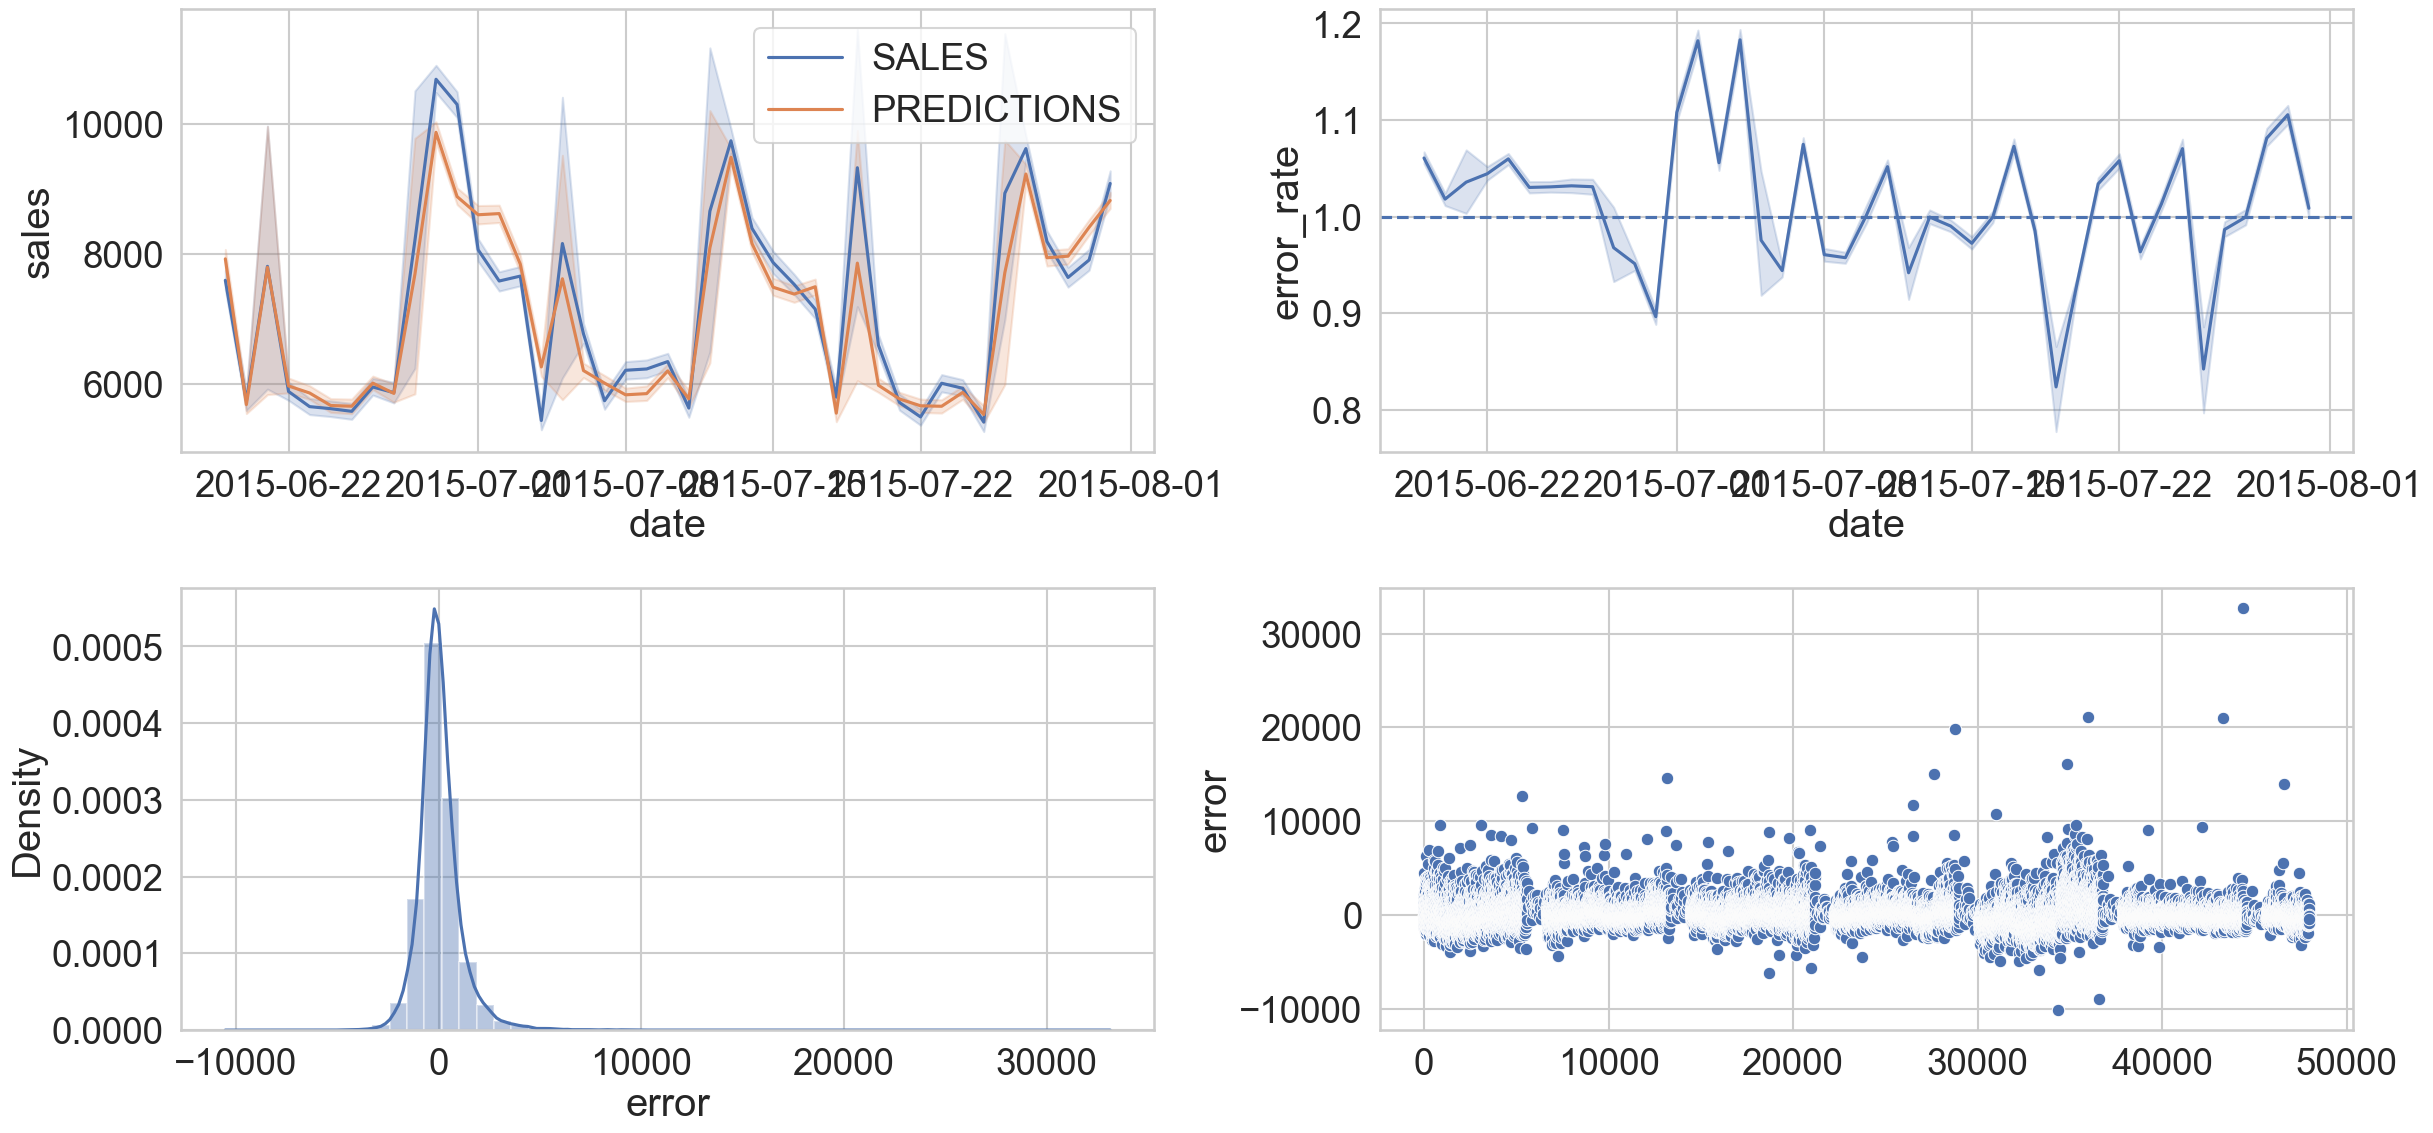

In [95]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')
plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )
plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['error'] )

# 10.0. MODEL DEPLOY TO PRODUCTION

In [96]:
# Save trained model
pickle.dump( rf_random, open( 
    'c:/Users/bruni/OneDrive/Documentos/Repos/rossmann_sales/model/model_rossmann.pkl', 'wb' ) )

## 10.1. Rossmann Class 

In [330]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='c:/Users/bruni/OneDrive/Documentos/Repos/rossmann_sales/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler 

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'c:/Users/bruni/OneDrive/Documentos/Repos/rossmann_sales/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

## 10.3. API Tester 

### 10.3.1. Test

In [34]:
 # loading test dataset
df10 = pd.read_csv( 'c:/Users/bruni/OneDrive/Documentos/Repos/rossmann_sales/data/test.csv' )


In [35]:
# merge test dataset + store
df_test = pd.merge( df10, data_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [36]:
 # convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [37]:
# API Call
url = 'http://192.168.0.93:5000/rossmann/predict'
#url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )


Status Code 200


In [38]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [39]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )


Store Number 20 will sell R$294,206.80 in the next 6 weeks
Store Number 22 will sell R$240,763.70 in the next 6 weeks
Store Number 23 will sell R$227,413.35 in the next 6 weeks


### 10.3.2. Ready to Predict 

In [50]:
# merge test dataset + store
df_test = pd.merge( df10, data_store_raw, how='left', on='Store' )

# choose store for prediction
#df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]
store_number = int(input("Enter the store number for the forecast: "))
df_test = df_test[df_test['Store'] == store_number]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

# API Call
url = 'http://192.168.0.93:5000/rossmann/predict'
#url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell ${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )
    
    

Status Code 200
Store Number 14 will sell $231,875.78 in the next 6 weeks
